# Directory check


In [64]:
import os

current_directory = os.getcwd()

absolute_path = os.path.abspath(os.path.join(current_directory,"../../../../data/CartPole-v1/jerbi/all_for_all/softmax/softmax_outputscaling_beta_tests/softmax_fixed_beta/softmax_5"))

print(absolute_path)

c:\Users\Bernardo\Desktop\Work\data\CartPole-v1\jerbi\all_for_all\softmax\softmax_outputscaling_beta_tests\softmax_fixed_beta\softmax_5


# Analysis class and auxiliar functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch.utils.tensorboard import SummaryWriter

In [2]:
def remove_leading_nones(nested_list):
    """
    Remove any sublist that starts with a None value from a nested list.

    Args:
        nested_list (list): A list of lists which may contain None values at the start.

    Returns:
        list: The modified list with sublists starting with None removed.
    """
    def clean_sublist(sublist):
        # Remove leading Nones from a sublist
        while sublist and sublist[0] is None:
            sublist.pop(0)
        return sublist

    def recursive_clean(lst):
        cleaned_list = []
        for item in lst:
            if isinstance(item, list):
                # Clean the sublist recursively
                cleaned_sublist = recursive_clean(item)
                if cleaned_sublist:
                    cleaned_list.append(clean_sublist(cleaned_sublist))
            elif item is not None:
                cleaned_list.append(item)
        return cleaned_list

    return recursive_clean(nested_list)

@staticmethod
def remove_repeated_gradients(grad_list):
    """
    Remove repeated gradients that were mistakenly saved multiple times per batch.

    Args:
        grad_list (list): A list of gradients where each gradient is repeated multiple times.

    Returns:
        list: A list with the repeated gradients removed.
    """
    cleaned_gradients = []
    seen_gradients = set()

    grad_list = remove_leading_nones(grad_list)
    for grad in grad_list:
        # Convert gradients to a tuple for hashable comparison
        grad_tuple = _convert_to_tuple(grad)
        if grad_tuple not in seen_gradients:
            seen_gradients.add(grad_tuple)
            cleaned_gradients.append(grad)

    return cleaned_gradients

@staticmethod
def _convert_to_tuple(grad):
    """
    Convert gradient arrays to a tuple for hashable comparison.
    """
    if isinstance(grad, np.ndarray):
        return tuple(grad.flatten())
    elif isinstance(grad, list):
        return tuple(_convert_to_tuple(g) for g in grad)
    else:
        return grad


In [3]:
class Analysis:
    def __init__(self, path_to_dir):
        self.path = path_to_dir
        separated_data = {
            'episode_reward': [],
            'loss': [],
            'runtime': [],
            'params_gradients': []
        }

        for subdir, dirs, files in os.walk(self.path):
            for file in files:
                if file.endswith('.npz'):
                    file_path = os.path.join(subdir, file)
                    if os.path.exists(file_path):
                        data = np.load(file_path, allow_pickle=True)
                        for key in separated_data:
                            if key in data:
                                separated_data[key].append(data[key].tolist())
        self.data = separated_data

    def get_rewards(self):
        return self.data["episode_reward"]

    def get_loss(self):
        return self.data["loss"]

    def get_runtime(self):
        return self.data["runtime"]

    def get_gradients(self):
        self.data['params_gradients'] = [remove_repeated_gradients(grad) for grad in self.data['params_gradients']]
        self.data['params_gradients'] = [[episode[:2] for episode in agent] for agent in self.data['params_gradients']]
        return self.data["params_gradients"]

    def get_moving_average(self, window_size=10):
        rewards = self.get_rewards()
        moving_averages = []
        for reward in rewards:
            moving_averages.append(pd.Series(reward).rolling(window_size).mean())
        return moving_averages

    def compute_mean_loss(self):
        # Get loss values
        losses = self.get_loss()

        # Determine the minimum number of episodes across all agents
        min_length = min(len(losses[i]) for i in range(len(losses)))

        # Trim each agent's loss values to the minimum length
        losses = [losses[i][:min_length] for i in range(len(losses))]

        # Convert losses to a numpy array with shape (n_agents, n_episodes)
        losses_array = np.array([np.squeeze(agent_losses) for agent_losses in losses])

        # Compute mean loss per episode across all agents
        mean_loss_per_episode = np.mean(losses_array, axis=0)

        return mean_loss_per_episode
    
    def compute_norm_and_variance(self):

        gradients = self.get_gradients()
        min_length = min([len(gradients[i]) for i in range(len(gradients))])

        gradients = [gradients[i][:min_length] for i in range(len(gradients))]

        def flatten_gradients(gradients):
            for i in range(len(gradients)):
                for j in range(len(gradients[i])):
                    gradients[i][j] = np.concatenate([lista.flatten() for lista in gradients[i][j]], axis = 0)

        flatten_gradients(gradients)

        gradients_array = np.array(gradients)

        magnitudes_gradients = np.linalg.norm(gradients_array, axis = 2)

        mean_magnitudes_gradients = np.insert(np.mean(magnitudes_gradients, axis = 0),0,0)

        std_magnitudes_gradients  = np.insert(np.var(magnitudes_gradients, axis = 0),0,0)

        return mean_magnitudes_gradients, std_magnitudes_gradients

# UQC

## UQC Raw vs Softmax

### Cartpole

In [4]:
uqc_policies_paths = [
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits_raw_contiguous",
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits_raw_parity",
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits"
]

# Initialize Analysis objects
uqc_model_raw_contiguous = Analysis(uqc_policies_paths[0])
uqc_model_raw_parity = Analysis(uqc_policies_paths[1])
uqc_model = Analysis(uqc_policies_paths[2])

# Calculate moving averages for rewards
uqc_model_raw_contiguous_rewards = uqc_model_raw_contiguous.get_moving_average(window_size=10)
uqc_model_raw_parity_rewards = uqc_model_raw_parity.get_moving_average(window_size=10)
uqc_model_rewards = uqc_model.get_moving_average(window_size=10)

# Compute mean and std for rewards
uqc_model_raw_contiguous_rewards_mean = np.mean(uqc_model_raw_contiguous_rewards, axis=0)
uqc_model_raw_parity_rewards_mean = np.mean(uqc_model_raw_parity_rewards, axis=0)
uqc_model_rewards_mean = np.mean(uqc_model_rewards, axis=0)

uqc_model_raw_contiguous_rewards_std = np.std(uqc_model_raw_contiguous_rewards, axis=0)
uqc_model_raw_parity_rewards_std = np.std(uqc_model_raw_parity_rewards, axis=0)
uqc_model_rewards_std = np.std(uqc_model_rewards, axis=0)

# Calculate gradients and their variance
uqc_model_raw_contiguous_norm_grads, uqc_model_raw_contiguous_variance_grads = uqc_model_raw_contiguous.compute_norm_and_variance()
uqc_model_raw_parity_norm_grads, uqc_model_raw_parity_variance_grads = uqc_model_raw_parity.compute_norm_and_variance()
uqc_model_norm_grads, uqc_model_variance_grads = uqc_model.compute_norm_and_variance()

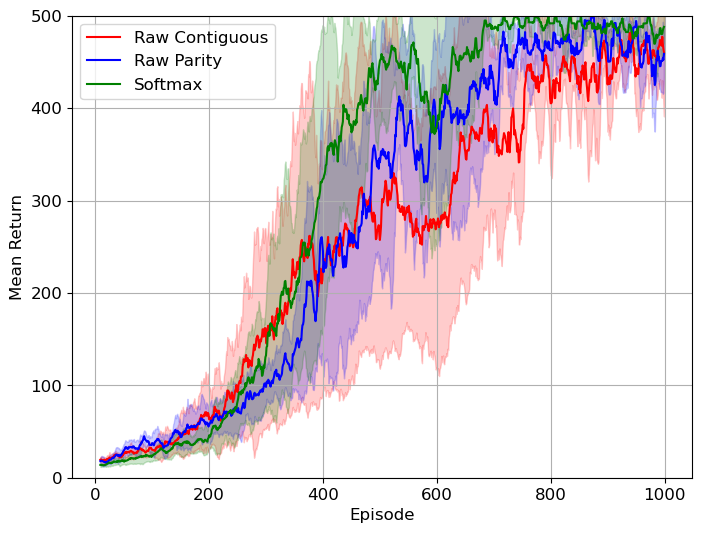

In [5]:
plt.figure(figsize=(8, 6))


plt.plot(uqc_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
plt.plot(uqc_model_raw_parity_rewards_mean, color="blue", label="Raw Parity")
plt.plot(uqc_model_rewards_mean, color="green", label="Softmax")
plt.fill_between(np.arange(len(uqc_model_raw_contiguous_rewards_mean)), 
                    np.clip(uqc_model_raw_contiguous_rewards_mean - uqc_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_raw_contiguous_rewards_mean + uqc_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
plt.fill_between(np.arange(len(uqc_model_raw_parity_rewards_mean)), 
                    np.clip(uqc_model_raw_parity_rewards_mean - uqc_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_raw_parity_rewards_mean + uqc_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
plt.fill_between(np.arange(len(uqc_model_rewards_mean)), 
                    np.clip(uqc_model_rewards_mean - uqc_model_rewards_std, a_min=0, a_max=500),
                    np.clip(uqc_model_rewards_mean + uqc_model_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.ylim(0,500)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.grid(True)
plt.savefig("../../../../data/CartPole-v1/UQC/uqc_policies_cartpole.pdf", format="pdf")

### Acrobot

In [6]:
uqc_policies_paths = [
    "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits_raw_contiguous",
    "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits"
]

# Initialize Analysis objects
uqc_model_raw_contiguous = Analysis(uqc_policies_paths[0])
uqc_model = Analysis(uqc_policies_paths[1])

# Calculate moving averages for rewards
uqc_model_raw_contiguous_rewards = uqc_model_raw_contiguous.get_moving_average(window_size=10)
uqc_model_rewards = uqc_model.get_moving_average(window_size=10)

# Compute mean and std for rewards
uqc_model_raw_contiguous_rewards_mean = np.mean(uqc_model_raw_contiguous_rewards, axis=0)
uqc_model_rewards_mean = np.mean(uqc_model_rewards, axis=0)

uqc_model_raw_contiguous_rewards_std = np.std(uqc_model_raw_contiguous_rewards, axis=0)
uqc_model_rewards_std = np.std(uqc_model_rewards, axis=0)

# Calculate gradients and their variance
uqc_model_raw_contiguous_norm_grads, uqc_model_raw_contiguous_variance_grads = uqc_model_raw_contiguous.compute_norm_and_variance()
uqc_model_norm_grads, uqc_model_variance_grads = uqc_model.compute_norm_and_variance()

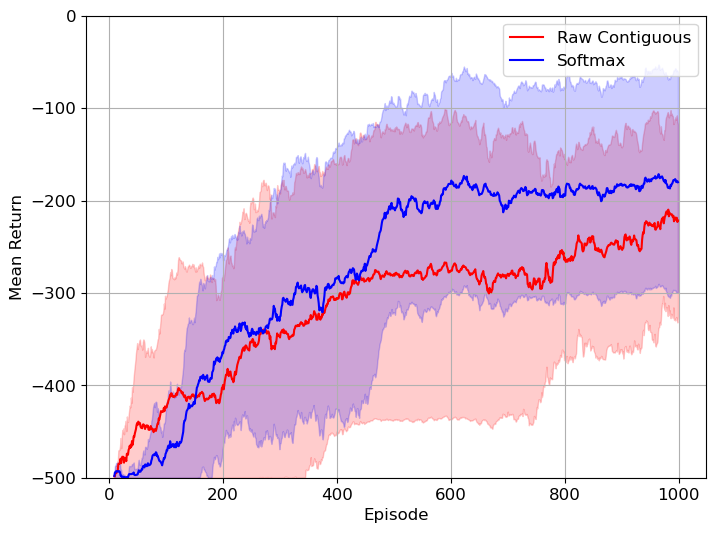

In [7]:
plt.figure(figsize=(8, 6))


plt.plot(uqc_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
plt.plot(uqc_model_rewards_mean, color="blue", label="Softmax")
plt.fill_between(np.arange(len(uqc_model_raw_contiguous_rewards_mean)), 
                    np.clip(uqc_model_raw_contiguous_rewards_mean - uqc_model_raw_contiguous_rewards_std, a_min=-500, a_max=0),
                    np.clip(uqc_model_raw_contiguous_rewards_mean + uqc_model_raw_contiguous_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="red")
plt.fill_between(np.arange(len(uqc_model_rewards_mean)), 
                    np.clip(uqc_model_rewards_mean - uqc_model_rewards_std, a_min=-500, a_max=0),
                    np.clip(uqc_model_rewards_mean + uqc_model_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="blue")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.ylim(-500,0)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.grid(True)
plt.savefig("../../../../data/Acrobot-v1/UQC/uqc_policies_acrobot.pdf", format="pdf")

## UQC 1-4 qubit

### Cartpole

In [8]:
UQC_FullEnc_paths= [ "../../../../data/CartPole-v1/UQC/UQC_FullEnc_1qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits_no_entangle",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits",
        "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits_no_entangle"]

UQC_FullEnc_1qubits = Analysis(UQC_FullEnc_paths[0])
UQC_FullEnc_2qubits = Analysis(UQC_FullEnc_paths[1])
UQC_FullEnc_2qubits_no_entangle = Analysis(UQC_FullEnc_paths[2])
UQC_FullEnc_4qubits = Analysis(UQC_FullEnc_paths[3])
UQC_FullEnc_4qubits_no_entangle = Analysis(UQC_FullEnc_paths[4])

UQC_FullEnc_1qubits_rewards = UQC_FullEnc_1qubits.get_moving_average(window_size=10)
UQC_FullEnc_2qubits_rewards = UQC_FullEnc_2qubits.get_moving_average(window_size=10)
UQC_FullEnc_2qubits_no_entangle_rewards = UQC_FullEnc_2qubits_no_entangle.get_moving_average(window_size=10)
UQC_FullEnc_4qubits_rewards = UQC_FullEnc_4qubits.get_moving_average(window_size=10)
UQC_FullEnc_4qubits_no_entangle_rewards = UQC_FullEnc_4qubits_no_entangle.get_moving_average(window_size=10)

UQC_FullEnc_1qubits_rewards_mean = np.mean(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_mean = np.mean(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_2qubits_no_entangle_rewards_mean = np.mean(UQC_FullEnc_2qubits_no_entangle_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_mean = np.mean(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_4qubits_no_entangle_rewards_mean = np.mean(UQC_FullEnc_4qubits_no_entangle_rewards, axis=0)

UQC_FullEnc_1qubits_rewards_std = np.std(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_std = np.std(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_2qubits_no_entangle_rewards_std = np.std(UQC_FullEnc_2qubits_no_entangle_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_std = np.std(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_4qubits_no_entangle_std = np.std(UQC_FullEnc_4qubits_no_entangle_rewards, axis=0)


UQC_FullEnc_1qubits_norm_grads,             UQC_FullEnc_1qubits_variance_grads = UQC_FullEnc_1qubits.compute_norm_and_variance()
UQC_FullEnc_2qubits_norm_grads,             UQC_FullEnc_2qubits_variance_grads = UQC_FullEnc_2qubits.compute_norm_and_variance()
UQC_FullEnc_2qubits_no_entangle_norm_grads, UQC_FullEnc_2qubits_no_entangle_variance_grads = UQC_FullEnc_2qubits_no_entangle.compute_norm_and_variance()
UQC_FullEnc_4qubits_norm_grads,             UQC_FullEnc_4qubits_variance_grads = UQC_FullEnc_4qubits.compute_norm_and_variance()
UQC_FullEnc_4qubits_no_entangle_norm_grads, UQC_FullEnc_4qubits_no_entangle_variance_grads = UQC_FullEnc_4qubits_no_entangle.compute_norm_and_variance()


UQC_FullEnc_1qubits_runtime = sum(map(sum, UQC_FullEnc_1qubits.get_runtime())) / len(UQC_FullEnc_1qubits.get_runtime())/60
UQC_FullEnc_2qubits_runtime = sum(map(sum, UQC_FullEnc_2qubits.get_runtime())) / len(UQC_FullEnc_2qubits.get_runtime())/60
UQC_FullEnc_2qubits_no_entangle_runtime = sum(map(sum, UQC_FullEnc_2qubits_no_entangle.get_runtime())) / len(UQC_FullEnc_2qubits_no_entangle.get_runtime())/60
UQC_FullEnc_4qubits_runtime = sum(map(sum, UQC_FullEnc_4qubits.get_runtime())) / len(UQC_FullEnc_4qubits.get_runtime())/60
UQC_FullEnc_4qubits_no_entangle_runtime = sum(map(sum, UQC_FullEnc_4qubits_no_entangle.get_runtime())) / len(UQC_FullEnc_4qubits_no_entangle.get_runtime())/60



UQC_PartialEnc_paths= ["../../../../data/CartPole-v1/UQC/UQC_PartialEnc_2qubits",
                        "../../../../data/CartPole-v1/UQC/UQC_PartialEnc_2qubits_no_entangle",
                        "../../../../data/CartPole-v1/UQC/UQC_PartialEnc_4qubits",
                        "../../../../data/CartPole-v1/UQC/UQC_PartialEnc_4qubits_no_entangle"]

UQC_PartialEnc_2qubits = Analysis(UQC_PartialEnc_paths[0])
UQC_PartialEnc_2qubits_no_entangle = Analysis(UQC_PartialEnc_paths[1])
UQC_PartialEnc_4qubits = Analysis(UQC_PartialEnc_paths[2])
UQC_PartialEnc_4qubits_no_entangle = Analysis(UQC_PartialEnc_paths[3])

UQC_PartialEnc_2qubits_rewards = UQC_PartialEnc_2qubits.get_moving_average(window_size=10)
UQC_PartialEnc_2qubits_no_entangle_rewards = UQC_PartialEnc_2qubits_no_entangle.get_moving_average(window_size=10)
UQC_PartialEnc_4qubits_rewards = UQC_PartialEnc_4qubits.get_moving_average(window_size=10)
UQC_PartialEnc_4qubits_no_entangle_rewards = UQC_PartialEnc_4qubits_no_entangle.get_moving_average(window_size=10)

UQC_PartialEnc_2qubits_rewards_mean = np.mean(UQC_PartialEnc_2qubits_rewards, axis=0)
UQC_PartialEnc_2qubits_no_entangle_rewards_mean = np.mean(UQC_PartialEnc_2qubits_no_entangle_rewards, axis=0)
UQC_PartialEnc_4qubits_rewards_mean = np.mean(UQC_PartialEnc_4qubits_rewards, axis=0)
UQC_PartialEnc_4qubits_no_entangle_rewards_mean = np.mean(UQC_PartialEnc_4qubits_no_entangle_rewards, axis=0)

UQC_PartialEnc_2qubits_rewards_std = np.std(UQC_PartialEnc_2qubits_rewards, axis=0)
UQC_PartialEnc_2qubits_no_entangle_rewards_std = np.std(UQC_PartialEnc_2qubits_no_entangle_rewards, axis=0)
UQC_PartialEnc_4qubits_rewards_std = np.std(UQC_PartialEnc_4qubits_rewards, axis=0)
UQC_PartialEnc_4qubits_no_entangle_std = np.std(UQC_PartialEnc_4qubits_no_entangle_rewards, axis=0)

UQC_PartialEnc_2qubits_norm_grads,             UQC_PartialEnc_2qubits_variance_grads = UQC_PartialEnc_2qubits.compute_norm_and_variance()
UQC_PartialEnc_2qubits_no_entangle_norm_grads, UQC_PartialEnc_2qubits_no_entangle_variance_grads = UQC_PartialEnc_2qubits_no_entangle.compute_norm_and_variance()
UQC_PartialEnc_4qubits_norm_grads,             UQC_PartialEnc_4qubits_variance_grads = UQC_PartialEnc_4qubits.compute_norm_and_variance()
UQC_PartialEnc_4qubits_no_entangle_norm_grads, UQC_PartialEnc_4qubits_no_entangle_variance_grads = UQC_PartialEnc_4qubits_no_entangle.compute_norm_and_variance()

UQC_PartialEnc_2qubits_runtime = sum(map(sum, UQC_PartialEnc_2qubits.get_runtime())) / len(UQC_PartialEnc_2qubits.get_runtime())/60
UQC_PartialEnc_2qubits_no_entangle_runtime = sum(map(sum, UQC_PartialEnc_2qubits_no_entangle.get_runtime())) / len(UQC_PartialEnc_2qubits_no_entangle.get_runtime())/60
UQC_PartialEnc_4qubits_runtime = sum(map(sum, UQC_PartialEnc_4qubits.get_runtime())) / len(UQC_PartialEnc_4qubits.get_runtime())/60
UQC_PartialEnc_4qubits_no_entangle_runtime = sum(map(sum, UQC_PartialEnc_4qubits_no_entangle.get_runtime())) / len(UQC_PartialEnc_4qubits_no_entangle.get_runtime())/60

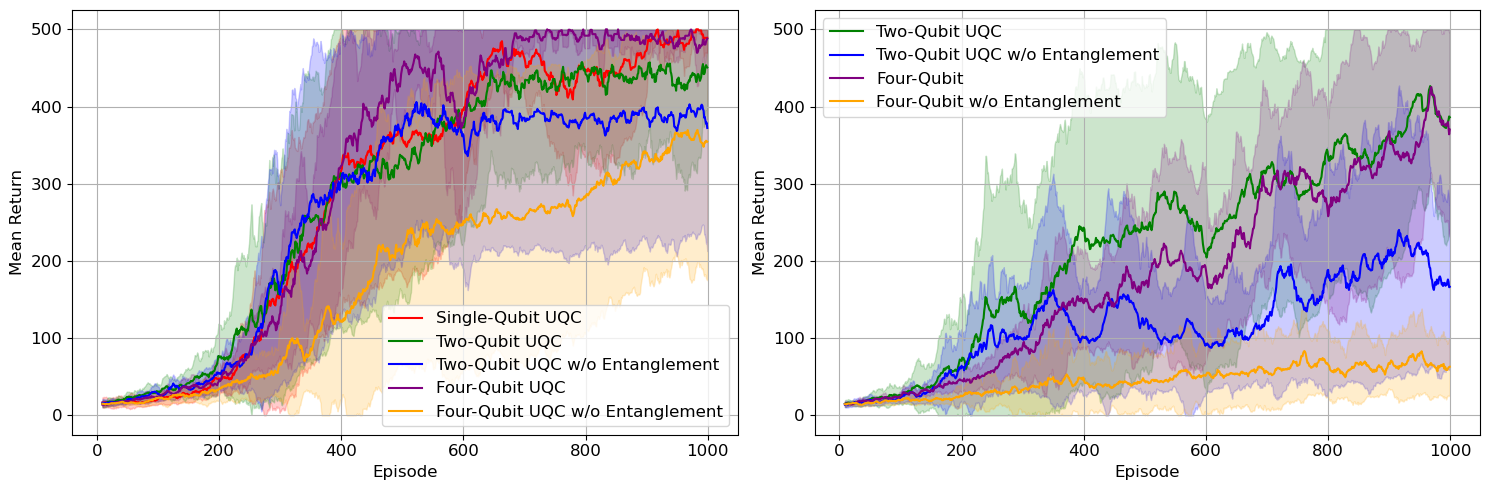

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

axs[0].plot(UQC_FullEnc_1qubits_rewards_mean, color="red", label="Single-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_rewards_mean, color="green", label="Two-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_no_entangle_rewards_mean, color="blue", label="Two-Qubit UQC w/o Entanglement")
axs[0].plot(UQC_FullEnc_4qubits_rewards_mean, color="purple", label="Four-Qubit UQC")
axs[0].plot(UQC_FullEnc_4qubits_no_entangle_rewards_mean, color="orange", label="Four-Qubit UQC w/o Entanglement")
axs[0].fill_between(np.arange(len(UQC_FullEnc_1qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_1qubits_rewards_mean - UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_1qubits_rewards_mean + UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_rewards_mean - UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_2qubits_rewards_mean + UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_no_entangle_rewards_mean - UQC_FullEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_2qubits_no_entangle_rewards_mean + UQC_FullEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_rewards_mean - UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_4qubits_rewards_mean + UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_no_entangle_rewards_mean - UQC_FullEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_4qubits_no_entangle_rewards_mean + UQC_FullEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    alpha=0.2, color="orange")
axs[0].set_xlabel("Episode", fontsize = 12)
axs[0].set_ylabel("Mean Return", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)



axs[1].plot(UQC_PartialEnc_2qubits_rewards_mean, color="green", label="Two-Qubit UQC")
axs[1].plot(UQC_PartialEnc_2qubits_no_entangle_rewards_mean, color="blue", label="Two-Qubit UQC w/o Entanglement")
axs[1].plot(UQC_PartialEnc_4qubits_rewards_mean, color="purple", label="Four-Qubit")
axs[1].plot(UQC_PartialEnc_4qubits_no_entangle_rewards_mean, color="orange", label="Four-Qubit w/o Entanglement")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_PartialEnc_2qubits_rewards_mean - UQC_PartialEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_2qubits_rewards_mean + UQC_PartialEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_2qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_PartialEnc_2qubits_no_entangle_rewards_mean - UQC_PartialEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_2qubits_no_entangle_rewards_mean + UQC_PartialEnc_2qubits_no_entangle_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_PartialEnc_4qubits_rewards_mean - UQC_PartialEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_4qubits_rewards_mean + UQC_PartialEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="purple")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_4qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_PartialEnc_4qubits_no_entangle_rewards_mean - UQC_PartialEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    np.clip(UQC_PartialEnc_4qubits_no_entangle_rewards_mean + UQC_PartialEnc_4qubits_no_entangle_std, a_min=0, a_max=500),
                    alpha=0.2, color="orange")
axs[1].set_xlabel("Episode", fontsize = 12)
axs[1].set_ylabel("Mean Return", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/CartPole-v1/UQC/uqc_encode_cartpole.pdf", format="pdf")

plt.show()

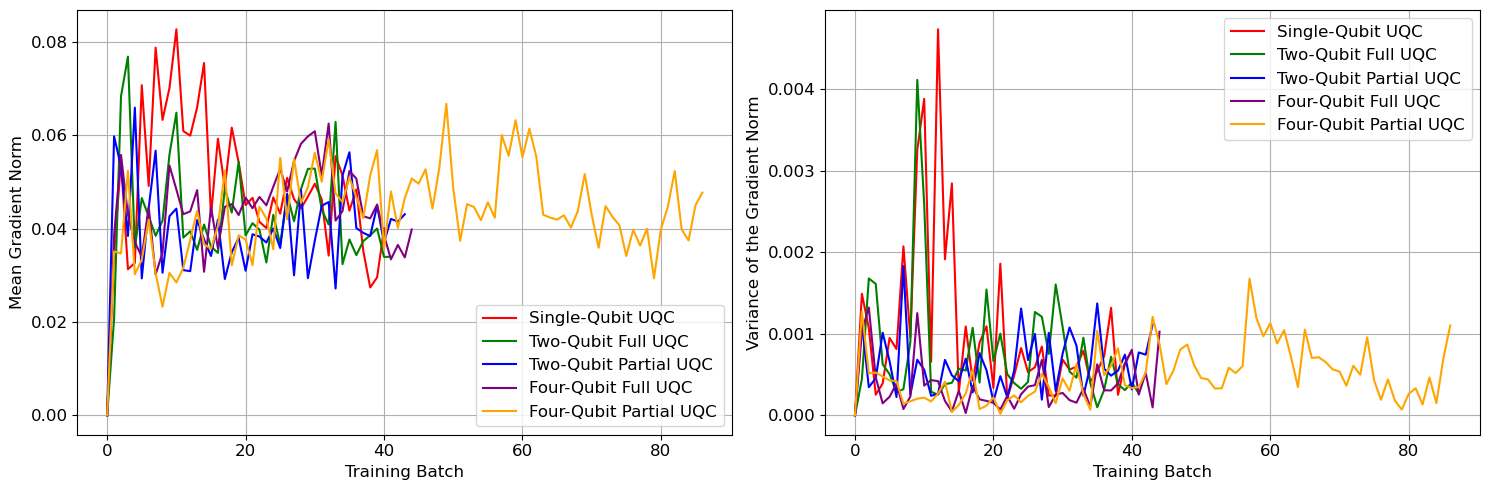

In [10]:
categories = ["Single-Qubit UQC", "Two-Qubit UQC", "Two-Qubit UQC w/o Entanglement", "Four-Qubit UQC", "Four-Qubit UQC w/o Entanglement"]
runtimes = [UQC_FullEnc_1qubits_runtime, UQC_FullEnc_2qubits_runtime, UQC_FullEnc_2qubits_no_entangle_runtime, 
            UQC_FullEnc_4qubits_runtime, UQC_FullEnc_4qubits_no_entangle_runtime]

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot mean gradient norms for Full Encoding in the first subplot (top-left)
axs[0].plot(UQC_FullEnc_1qubits_norm_grads, color="red", label="Single-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_norm_grads, color="green", label="Two-Qubit Full UQC")
axs[0].plot(UQC_PartialEnc_2qubits_norm_grads, color="blue", label="Two-Qubit Partial UQC")
axs[0].plot(UQC_FullEnc_4qubits_norm_grads, color="purple", label="Four-Qubit Full UQC")
axs[0].plot(UQC_PartialEnc_4qubits_norm_grads, color="orange", label="Four-Qubit Partial UQC")
axs[0].set_xlabel("Training Batch", fontsize=12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot variance of gradient norms for Full Encoding in the second subplot (top-right)
axs[1].plot(UQC_FullEnc_1qubits_variance_grads, color="red", label="Single-Qubit UQC")
axs[1].plot(UQC_FullEnc_2qubits_variance_grads, color="green", label="Two-Qubit Full UQC")
axs[1].plot(UQC_PartialEnc_2qubits_variance_grads, color="blue", label="Two-Qubit Partial UQC")
axs[1].plot(UQC_FullEnc_4qubits_variance_grads, color="purple", label="Four-Qubit Full UQC")
axs[1].plot(UQC_PartialEnc_4qubits_variance_grads, color="orange", label="Four-Qubit Partial UQC")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Automatically adjust layout for better fit
plt.tight_layout()

plt.savefig("../../../../data/CartPole-v1/UQC/uqc_gradients_cartpole.pdf", format="pdf")

# Show the plot
plt.show()

### Acrobot

In [11]:
UQC_FullEnc_paths= [ "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_1qubits",
        "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_2qubits",
        "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_2qubits_no_entangle",
        "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits",
        "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits_no_entangle"]

UQC_FullEnc_1qubits = Analysis(UQC_FullEnc_paths[0])
UQC_FullEnc_2qubits = Analysis(UQC_FullEnc_paths[1])
UQC_FullEnc_2qubits_no_entangle = Analysis(UQC_FullEnc_paths[2])
UQC_FullEnc_4qubits = Analysis(UQC_FullEnc_paths[3])
UQC_FullEnc_4qubits_no_entangle = Analysis(UQC_FullEnc_paths[4])

UQC_FullEnc_1qubits_rewards = UQC_FullEnc_1qubits.get_moving_average(window_size=10)
UQC_FullEnc_2qubits_rewards = UQC_FullEnc_2qubits.get_moving_average(window_size=10)
UQC_FullEnc_2qubits_no_entangle_rewards = UQC_FullEnc_2qubits_no_entangle.get_moving_average(window_size=10)
UQC_FullEnc_4qubits_rewards = UQC_FullEnc_4qubits.get_moving_average(window_size=10)
UQC_FullEnc_4qubits_no_entangle_rewards = UQC_FullEnc_4qubits_no_entangle.get_moving_average(window_size=10)

UQC_FullEnc_1qubits_rewards_mean = np.mean(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_mean = np.mean(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_2qubits_no_entangle_rewards_mean = np.mean(UQC_FullEnc_2qubits_no_entangle_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_mean = np.mean(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_4qubits_no_entangle_rewards_mean = np.mean(UQC_FullEnc_4qubits_no_entangle_rewards, axis=0)

UQC_FullEnc_1qubits_rewards_std = np.std(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_std = np.std(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_2qubits_no_entangle_rewards_std = np.std(UQC_FullEnc_2qubits_no_entangle_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_std = np.std(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_4qubits_no_entangle_std = np.std(UQC_FullEnc_4qubits_no_entangle_rewards, axis=0)


UQC_FullEnc_1qubits_norm_grads,             UQC_FullEnc_1qubits_variance_grads = UQC_FullEnc_1qubits.compute_norm_and_variance()
UQC_FullEnc_2qubits_norm_grads,             UQC_FullEnc_2qubits_variance_grads = UQC_FullEnc_2qubits.compute_norm_and_variance()
UQC_FullEnc_2qubits_no_entangle_norm_grads, UQC_FullEnc_2qubits_no_entangle_variance_grads = UQC_FullEnc_2qubits_no_entangle.compute_norm_and_variance()
UQC_FullEnc_4qubits_norm_grads,             UQC_FullEnc_4qubits_variance_grads = UQC_FullEnc_4qubits.compute_norm_and_variance()
UQC_FullEnc_4qubits_no_entangle_norm_grads, UQC_FullEnc_4qubits_no_entangle_variance_grads = UQC_FullEnc_4qubits_no_entangle.compute_norm_and_variance()


UQC_FullEnc_1qubits_runtime = sum(map(sum, UQC_FullEnc_1qubits.get_runtime())) / len(UQC_FullEnc_1qubits.get_runtime())/60
UQC_FullEnc_2qubits_runtime = sum(map(sum, UQC_FullEnc_2qubits.get_runtime())) / len(UQC_FullEnc_2qubits.get_runtime())/60
UQC_FullEnc_2qubits_no_entangle_runtime = sum(map(sum, UQC_FullEnc_2qubits_no_entangle.get_runtime())) / len(UQC_FullEnc_2qubits_no_entangle.get_runtime())/60
UQC_FullEnc_4qubits_runtime = sum(map(sum, UQC_FullEnc_4qubits.get_runtime())) / len(UQC_FullEnc_4qubits.get_runtime())/60
UQC_FullEnc_4qubits_no_entangle_runtime = sum(map(sum, UQC_FullEnc_4qubits_no_entangle.get_runtime())) / len(UQC_FullEnc_4qubits_no_entangle.get_runtime())/60



UQC_PartialEnc_paths= ["../../../../data/Acrobot-v1/UQC/UQC_PartialEnc_2qubits",
                        "../../../../data/Acrobot-v1/UQC/UQC_PartialEnc_2qubits_no_entangle",
                        "../../../../data/Acrobot-v1/UQC/UQC_PartialEnc_4qubits",
                        "../../../../data/Acrobot-v1/UQC/UQC_PartialEnc_4qubits_no_entangle"]

UQC_PartialEnc_2qubits = Analysis(UQC_PartialEnc_paths[0])
UQC_PartialEnc_2qubits_no_entangle = Analysis(UQC_PartialEnc_paths[1])
UQC_PartialEnc_4qubits = Analysis(UQC_PartialEnc_paths[2])
UQC_PartialEnc_4qubits_no_entangle = Analysis(UQC_PartialEnc_paths[3])

UQC_PartialEnc_2qubits_rewards = UQC_PartialEnc_2qubits.get_moving_average(window_size=10)
UQC_PartialEnc_2qubits_no_entangle_rewards = UQC_PartialEnc_2qubits_no_entangle.get_moving_average(window_size=10)
UQC_PartialEnc_4qubits_rewards = UQC_PartialEnc_4qubits.get_moving_average(window_size=10)
UQC_PartialEnc_4qubits_no_entangle_rewards = UQC_PartialEnc_4qubits_no_entangle.get_moving_average(window_size=10)

UQC_PartialEnc_2qubits_rewards_mean = np.mean(UQC_PartialEnc_2qubits_rewards, axis=0)
UQC_PartialEnc_2qubits_no_entangle_rewards_mean = np.mean(UQC_PartialEnc_2qubits_no_entangle_rewards, axis=0)
UQC_PartialEnc_4qubits_rewards_mean = np.mean(UQC_PartialEnc_4qubits_rewards, axis=0)
UQC_PartialEnc_4qubits_no_entangle_rewards_mean = np.mean(UQC_PartialEnc_4qubits_no_entangle_rewards, axis=0)

UQC_PartialEnc_2qubits_rewards_std = np.std(UQC_PartialEnc_2qubits_rewards, axis=0)
UQC_PartialEnc_2qubits_no_entangle_rewards_std = np.std(UQC_PartialEnc_2qubits_no_entangle_rewards, axis=0)
UQC_PartialEnc_4qubits_rewards_std = np.std(UQC_PartialEnc_4qubits_rewards, axis=0)
UQC_PartialEnc_4qubits_no_entangle_std = np.std(UQC_PartialEnc_4qubits_no_entangle_rewards, axis=0)

UQC_PartialEnc_2qubits_norm_grads,             UQC_PartialEnc_2qubits_variance_grads = UQC_PartialEnc_2qubits.compute_norm_and_variance()
UQC_PartialEnc_2qubits_no_entangle_norm_grads, UQC_PartialEnc_2qubits_no_entangle_variance_grads = UQC_PartialEnc_2qubits_no_entangle.compute_norm_and_variance()
UQC_PartialEnc_4qubits_norm_grads,             UQC_PartialEnc_4qubits_variance_grads = UQC_PartialEnc_4qubits.compute_norm_and_variance()
UQC_PartialEnc_4qubits_no_entangle_norm_grads, UQC_PartialEnc_4qubits_no_entangle_variance_grads = UQC_PartialEnc_4qubits_no_entangle.compute_norm_and_variance()

UQC_PartialEnc_2qubits_runtime = sum(map(sum, UQC_PartialEnc_2qubits.get_runtime())) / len(UQC_PartialEnc_2qubits.get_runtime())/60
UQC_PartialEnc_2qubits_no_entangle_runtime = sum(map(sum, UQC_PartialEnc_2qubits_no_entangle.get_runtime())) / len(UQC_PartialEnc_2qubits_no_entangle.get_runtime())/60
UQC_PartialEnc_4qubits_runtime = sum(map(sum, UQC_PartialEnc_4qubits.get_runtime())) / len(UQC_PartialEnc_4qubits.get_runtime())/60
UQC_PartialEnc_4qubits_no_entangle_runtime = sum(map(sum, UQC_PartialEnc_4qubits_no_entangle.get_runtime())) / len(UQC_PartialEnc_4qubits_no_entangle.get_runtime())/60

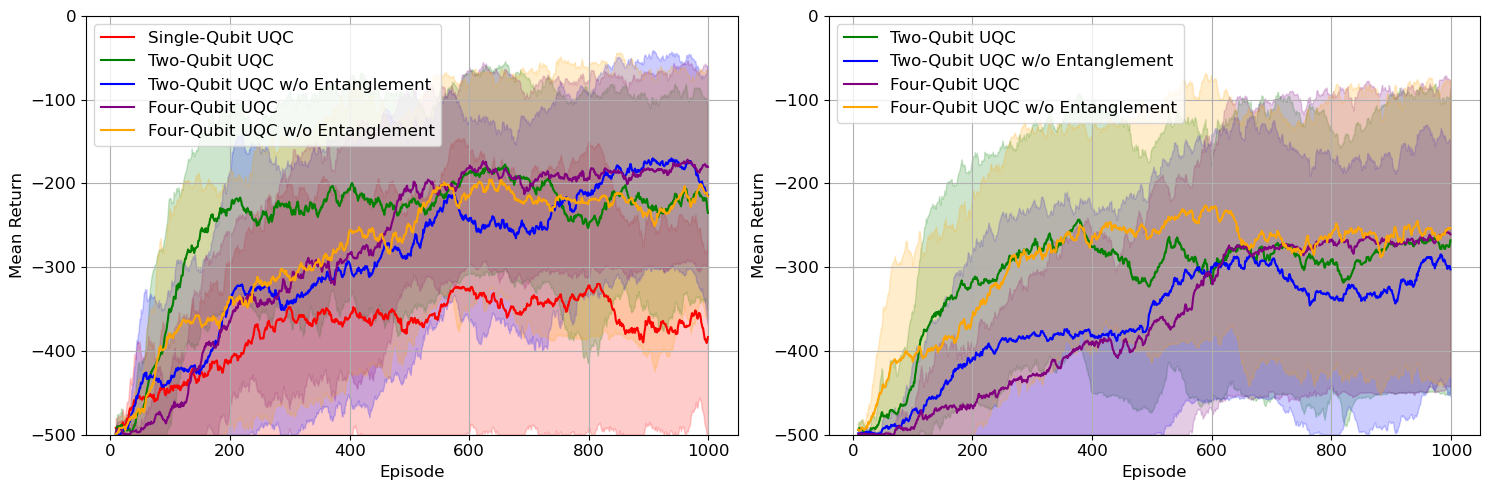

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

axs[0].plot(UQC_FullEnc_1qubits_rewards_mean, color="red", label="Single-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_rewards_mean, color="green", label="Two-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_no_entangle_rewards_mean, color="blue", label="Two-Qubit UQC w/o Entanglement")
axs[0].plot(UQC_FullEnc_4qubits_rewards_mean, color="purple", label="Four-Qubit UQC")
axs[0].plot(UQC_FullEnc_4qubits_no_entangle_rewards_mean, color="orange", label="Four-Qubit UQC w/o Entanglement")
axs[0].fill_between(np.arange(len(UQC_FullEnc_1qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_1qubits_rewards_mean - UQC_FullEnc_1qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_1qubits_rewards_mean + UQC_FullEnc_1qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_rewards_mean - UQC_FullEnc_2qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_2qubits_rewards_mean + UQC_FullEnc_2qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_no_entangle_rewards_mean - UQC_FullEnc_2qubits_no_entangle_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_2qubits_no_entangle_rewards_mean + UQC_FullEnc_2qubits_no_entangle_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_rewards_mean - UQC_FullEnc_4qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_4qubits_rewards_mean + UQC_FullEnc_4qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_no_entangle_rewards_mean - UQC_FullEnc_4qubits_no_entangle_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_4qubits_no_entangle_rewards_mean + UQC_FullEnc_4qubits_no_entangle_std, a_min=-500, a_max=0),
                    alpha=0.2, color="orange")
axs[0].set_xlabel("Episode", fontsize = 12)
axs[0].set_ylabel("Mean Return", fontsize = 12)
axs[0].set_ylim(-500,0)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].legend(fontsize=12, loc = 'upper left')
axs[0].grid(True)



axs[1].plot(UQC_PartialEnc_2qubits_rewards_mean, color="green", label="Two-Qubit UQC")
axs[1].plot(UQC_PartialEnc_2qubits_no_entangle_rewards_mean, color="blue", label="Two-Qubit UQC w/o Entanglement")
axs[1].plot(UQC_PartialEnc_4qubits_rewards_mean, color="purple", label="Four-Qubit UQC")
axs[1].plot(UQC_PartialEnc_4qubits_no_entangle_rewards_mean, color="orange", label="Four-Qubit UQC w/o Entanglement")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_PartialEnc_2qubits_rewards_mean - UQC_PartialEnc_2qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_PartialEnc_2qubits_rewards_mean + UQC_PartialEnc_2qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_2qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_PartialEnc_2qubits_no_entangle_rewards_mean - UQC_PartialEnc_2qubits_no_entangle_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_PartialEnc_2qubits_no_entangle_rewards_mean + UQC_PartialEnc_2qubits_no_entangle_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_PartialEnc_4qubits_rewards_mean - UQC_PartialEnc_4qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_PartialEnc_4qubits_rewards_mean + UQC_PartialEnc_4qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="purple")
axs[1].fill_between(np.arange(len(UQC_PartialEnc_4qubits_no_entangle_rewards_mean)), 
                    np.clip(UQC_PartialEnc_4qubits_no_entangle_rewards_mean - UQC_PartialEnc_4qubits_no_entangle_std, a_min=-500, a_max=0),
                    np.clip(UQC_PartialEnc_4qubits_no_entangle_rewards_mean + UQC_PartialEnc_4qubits_no_entangle_std, a_min=-500, a_max=0),
                    alpha=0.2, color="orange")
axs[1].set_xlabel("Episode", fontsize = 12)
axs[1].set_ylabel("Mean Return", fontsize = 12)
axs[1].set_ylim(-500,0)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].legend(fontsize=12,loc='upper left')
axs[1].grid(True)

plt.savefig("../../../../data/Acrobot-v1/UQC/uqc_encode_acrobot.pdf", format="pdf")

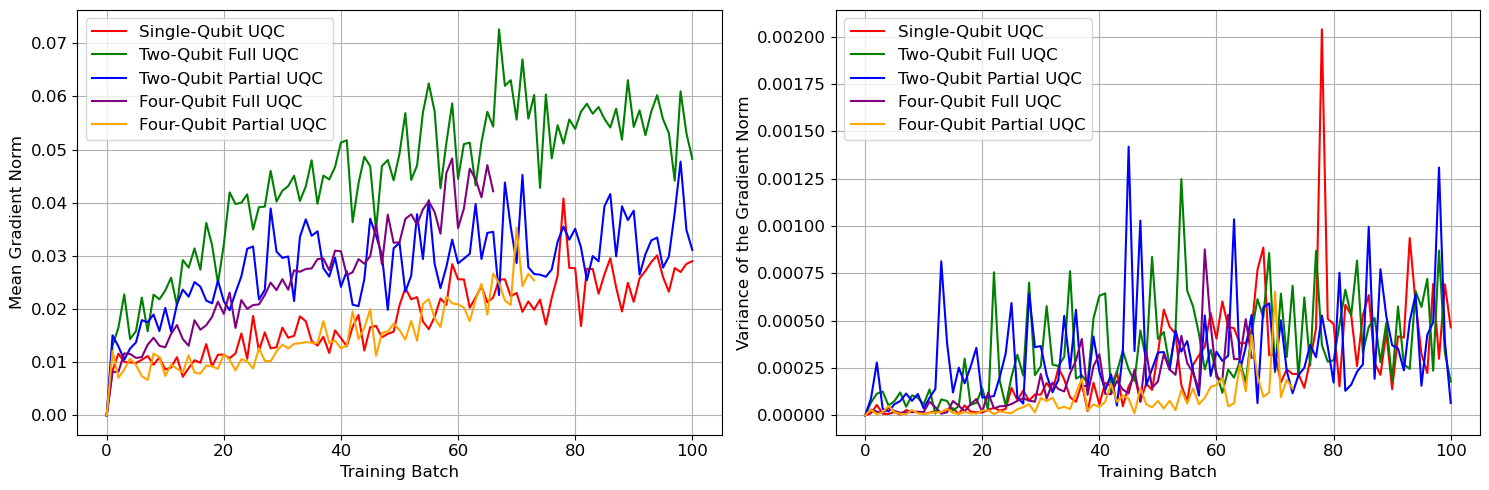

In [13]:
categories = ["Single-Qubit UQC", "Two-Qubit UQC", "Two-Qubit UQC w/o Entanglement", "Four-Qubit UQC", "Four-Qubit UQC w/o Entanglement"]
runtimes = [UQC_FullEnc_1qubits_runtime, UQC_FullEnc_2qubits_runtime, UQC_FullEnc_2qubits_no_entangle_runtime, 
            UQC_FullEnc_4qubits_runtime, UQC_FullEnc_4qubits_no_entangle_runtime]

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot mean gradient norms for Full Encoding in the first subplot (top-left)
axs[0].plot(UQC_FullEnc_1qubits_norm_grads, color="red", label="Single-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_norm_grads, color="green", label="Two-Qubit Full UQC")
axs[0].plot(UQC_PartialEnc_2qubits_norm_grads, color="blue", label="Two-Qubit Partial UQC")
axs[0].plot(UQC_FullEnc_4qubits_norm_grads, color="purple", label="Four-Qubit Full UQC")
axs[0].plot(UQC_PartialEnc_4qubits_norm_grads, color="orange", label="Four-Qubit Partial UQC")
axs[0].set_xlabel("Training Batch", fontsize=12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[0].legend(fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot variance of gradient norms for Full Encoding in the second subplot (top-right)
axs[1].plot(UQC_FullEnc_1qubits_variance_grads, color="red", label="Single-Qubit UQC")
axs[1].plot(UQC_FullEnc_2qubits_variance_grads, color="green", label="Two-Qubit Full UQC")
axs[1].plot(UQC_PartialEnc_2qubits_variance_grads, color="blue", label="Two-Qubit Partial UQC")
axs[1].plot(UQC_FullEnc_4qubits_variance_grads, color="purple", label="Four-Qubit Full UQC")
axs[1].plot(UQC_PartialEnc_4qubits_variance_grads, color="orange", label="Four-Qubit Partial UQC")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Automatically adjust layout for better fit
plt.tight_layout()

plt.savefig("../../../../data/Acrobot-v1/UQC/uqc_gradients_acrobot.pdf", format="pdf")

# Show the plot
plt.show()

## UQC Beta Schedule

### Cartpole

In [14]:
uqc_beta_paths = [
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits",
    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits_beta",
]

# Initialize Analysis objects
uqc_model_1qubit = Analysis(uqc_beta_paths[0])
uqc_model_1qubit_beta = Analysis(uqc_beta_paths[1])

# Calculate moving averages for rewards
uqc_model_1qubit_rewards = uqc_model_1qubit.get_moving_average(window_size=10)
uqc_model_1qubit_beta_rewards = uqc_model_1qubit_beta.get_moving_average(window_size=10)
# Compute mean and std for rewards
uqc_model_1qubit_rewards_mean = np.mean(uqc_model_1qubit_rewards, axis=0)
uqc_model_1qubit_beta_rewards_mean = np.mean(uqc_model_1qubit_beta_rewards, axis=0)
uqc_model_1qubit_rewards_std = np.std(uqc_model_1qubit_rewards, axis=0)
uqc_model_1qubit_beta_rewards_std = np.std(uqc_model_1qubit_beta_rewards, axis=0)

uqc_model_1qubit_loss = uqc_model_1qubit.compute_mean_loss()
uqc_model_1qubit_beta_loss = uqc_model_1qubit_beta.compute_mean_loss()

# Calculate gradients and their variance
uqc_model_1qubit_norm_grads, uqc_model_1qubit_variance_grads = uqc_model_1qubit.compute_norm_and_variance()
uqc_model_1qubit_beta_norm_grads, uqc_model_1qubit_beta_variance_grads = uqc_model_1qubit_beta.compute_norm_and_variance()

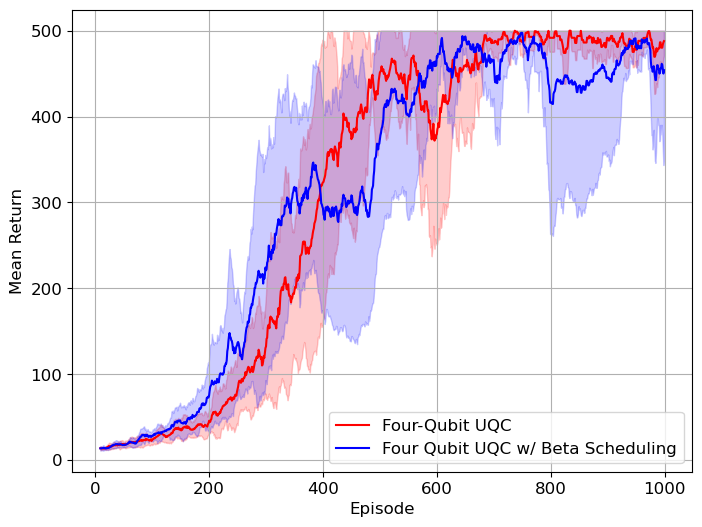

In [15]:
plt.figure(figsize=(8, 6))

plt.plot(uqc_model_1qubit_rewards_mean, color="red", label="Four-Qubit UQC")
plt.plot(uqc_model_1qubit_beta_rewards_mean, color="blue", label="Four Qubit UQC w/ Beta Scheduling")
plt.fill_between(np.arange(len(uqc_model_1qubit_rewards_mean)), 
                       np.clip(uqc_model_1qubit_rewards_mean - uqc_model_1qubit_rewards_std, a_min=0, a_max=500),
                       np.clip(uqc_model_1qubit_rewards_mean + uqc_model_1qubit_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="red")
plt.fill_between(np.arange(len(uqc_model_1qubit_beta_rewards_mean)), 
                       np.clip(uqc_model_1qubit_beta_rewards_mean - uqc_model_1qubit_beta_rewards_std, a_min=0, a_max=500),
                       np.clip(uqc_model_1qubit_beta_rewards_mean + uqc_model_1qubit_beta_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="blue")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize = 12)
plt.grid(True)

plt.savefig("../../../../data/CartPole-v1/UQC/uqc_beta_cartpole.pdf", format="pdf")

plt.show()

### Acrobot

In [16]:
uqc_beta_paths = [
    "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits",
    "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits_beta",
]

# Initialize Analysis objects
uqc_model_1qubit = Analysis(uqc_beta_paths[0])
uqc_model_1qubit_beta = Analysis(uqc_beta_paths[1])

# Calculate moving averages for rewards
uqc_model_1qubit_rewards = uqc_model_1qubit.get_moving_average(window_size=10)
uqc_model_1qubit_beta_rewards = uqc_model_1qubit_beta.get_moving_average(window_size=10)
# Compute mean and std for rewards
uqc_model_1qubit_rewards_mean = np.mean(uqc_model_1qubit_rewards, axis=0)
uqc_model_1qubit_beta_rewards_mean = np.mean(uqc_model_1qubit_beta_rewards, axis=0)
uqc_model_1qubit_rewards_std = np.std(uqc_model_1qubit_rewards, axis=0)
uqc_model_1qubit_beta_rewards_std = np.std(uqc_model_1qubit_beta_rewards, axis=0)

uqc_model_1qubit_loss = uqc_model_1qubit.compute_mean_loss()
uqc_model_1qubit_beta_loss = uqc_model_1qubit_beta.compute_mean_loss()

# Calculate gradients and their variance
uqc_model_1qubit_norm_grads, uqc_model_1qubit_variance_grads = uqc_model_1qubit.compute_norm_and_variance()
uqc_model_1qubit_beta_norm_grads, uqc_model_1qubit_beta_variance_grads = uqc_model_1qubit_beta.compute_norm_and_variance()

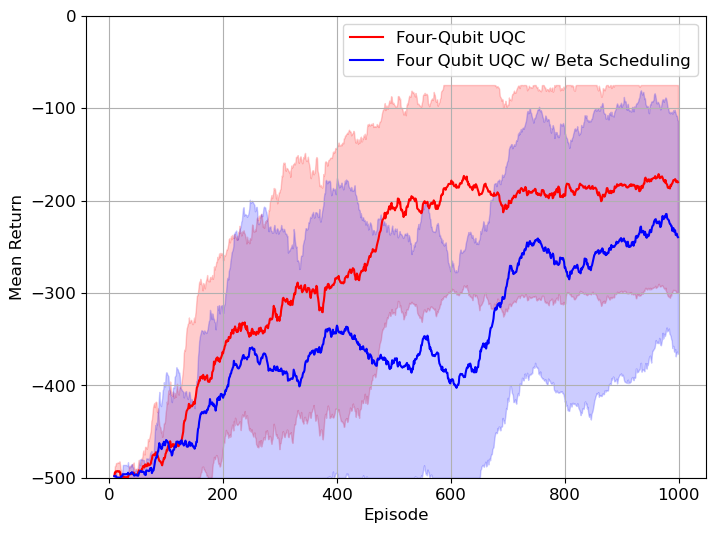

In [17]:
plt.figure(figsize=(8, 6))

plt.plot(uqc_model_1qubit_rewards_mean, color="red", label="Four-Qubit UQC")
plt.plot(uqc_model_1qubit_beta_rewards_mean, color="blue", label="Four Qubit UQC w/ Beta Scheduling")
plt.fill_between(np.arange(len(uqc_model_1qubit_rewards_mean)), 
                       np.clip(uqc_model_1qubit_rewards_mean - uqc_model_1qubit_rewards_std, a_min=-500, a_max=-75),
                       np.clip(uqc_model_1qubit_rewards_mean + uqc_model_1qubit_rewards_std, a_min=-500, a_max=-75),
                       alpha=0.2, color="red")
plt.fill_between(np.arange(len(uqc_model_1qubit_beta_rewards_mean)), 
                       np.clip(uqc_model_1qubit_beta_rewards_mean - uqc_model_1qubit_beta_rewards_std, a_min=-500, a_max=-75),
                       np.clip(uqc_model_1qubit_beta_rewards_mean + uqc_model_1qubit_beta_rewards_std, a_min=-500, a_max=-75),
                       alpha=0.2, color="blue")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.ylim(-500,0)
plt.legend(fontsize = 12)
plt.grid(True)

plt.savefig("../../../../data/Acrobot-v1/UQC/uqc_beta_acrobot.pdf", format="pdf")

plt.show()

## UQC Qubit scalling test

### Cartpole

In [18]:
UQC_FullEnc_paths = [ "../../../../data/CartPole-v1/UQC/UQC_FullEnc_1qubits",
                      "../../../../data/CartPole-v1/UQC/UQC_FullEnc_2qubits",
                      "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits",
                      "../../../../data/CartPole-v1/UQC/UQC_FullEnc_6qubits",
                      "../../../../data/CartPole-v1/UQC/UQC_FullEnc_8qubits",
                      "../../../../data/CartPole-v1/UQC/UQC_FullEnc_10qubits"]

# Initialize Analysis objects
UQC_FullEnc_1qubits = Analysis(UQC_FullEnc_paths[0])
UQC_FullEnc_2qubits = Analysis(UQC_FullEnc_paths[1])
UQC_FullEnc_4qubits = Analysis(UQC_FullEnc_paths[2])
UQC_FullEnc_6qubits = Analysis(UQC_FullEnc_paths[3])
UQC_FullEnc_8qubits = Analysis(UQC_FullEnc_paths[4])
UQC_FullEnc_10qubits = Analysis(UQC_FullEnc_paths[5])

# Compute moving averages for all qubit sizes
UQC_FullEnc_1qubits_rewards = UQC_FullEnc_1qubits.get_moving_average(window_size=10)
UQC_FullEnc_2qubits_rewards = UQC_FullEnc_2qubits.get_moving_average(window_size=10)
UQC_FullEnc_4qubits_rewards = UQC_FullEnc_4qubits.get_moving_average(window_size=10)
UQC_FullEnc_6qubits_rewards = UQC_FullEnc_6qubits.get_moving_average(window_size=10)
UQC_FullEnc_8qubits_rewards = UQC_FullEnc_8qubits.get_moving_average(window_size=10)
UQC_FullEnc_10qubits_rewards = UQC_FullEnc_10qubits.get_moving_average(window_size=10)

UQC_FullEnc_1qubits_rewards_mean = np.mean(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_mean = np.mean(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_mean = np.mean(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_6qubits_rewards_mean = np.mean(UQC_FullEnc_6qubits_rewards, axis=0)
UQC_FullEnc_8qubits_rewards_mean = np.mean(UQC_FullEnc_8qubits_rewards, axis=0)
UQC_FullEnc_10qubits_rewards_mean = np.mean(UQC_FullEnc_10qubits_rewards, axis=0)

UQC_FullEnc_1qubits_rewards_std = np.std(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_std = np.std(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_std = np.std(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_6qubits_rewards_std = np.std(UQC_FullEnc_6qubits_rewards, axis=0)
UQC_FullEnc_8qubits_rewards_std = np.std(UQC_FullEnc_8qubits_rewards, axis=0)
UQC_FullEnc_10qubits_rewards_std = np.std(UQC_FullEnc_10qubits_rewards, axis=0)



# Calculate gradients for all qubit sizes
UQC_FullEnc_1qubits_norm_grads, UQC_FullEnc_1qubits_variance_grads = UQC_FullEnc_1qubits.compute_norm_and_variance()
UQC_FullEnc_2qubits_norm_grads, UQC_FullEnc_2qubits_variance_grads = UQC_FullEnc_2qubits.compute_norm_and_variance()
UQC_FullEnc_4qubits_norm_grads, UQC_FullEnc_4qubits_variance_grads = UQC_FullEnc_4qubits.compute_norm_and_variance()
UQC_FullEnc_6qubits_norm_grads, UQC_FullEnc_6qubits_variance_grads = UQC_FullEnc_6qubits.compute_norm_and_variance()
UQC_FullEnc_8qubits_norm_grads, UQC_FullEnc_8qubits_variance_grads = UQC_FullEnc_8qubits.compute_norm_and_variance()
UQC_FullEnc_10qubits_norm_grads, UQC_FullEnc_10qubits_variance_grads = UQC_FullEnc_10qubits.compute_norm_and_variance()

# Calculate runtimes for all qubit sizes
UQC_FullEnc_1qubits_runtime = sum(map(sum, UQC_FullEnc_1qubits.get_runtime())) / len(UQC_FullEnc_1qubits.get_runtime()) / 60
UQC_FullEnc_2qubits_runtime = sum(map(sum, UQC_FullEnc_2qubits.get_runtime())) / len(UQC_FullEnc_2qubits.get_runtime()) / 60
UQC_FullEnc_4qubits_runtime = sum(map(sum, UQC_FullEnc_4qubits.get_runtime())) / len(UQC_FullEnc_4qubits.get_runtime()) / 60
UQC_FullEnc_6qubits_runtime = sum(map(sum, UQC_FullEnc_6qubits.get_runtime())) / len(UQC_FullEnc_6qubits.get_runtime()) / 60
UQC_FullEnc_8qubits_runtime = sum(map(sum, UQC_FullEnc_8qubits.get_runtime())) / len(UQC_FullEnc_8qubits.get_runtime()) / 60
UQC_FullEnc_10qubits_runtime = sum(map(sum, UQC_FullEnc_10qubits.get_runtime())) / len(UQC_FullEnc_10qubits.get_runtime()) / 60

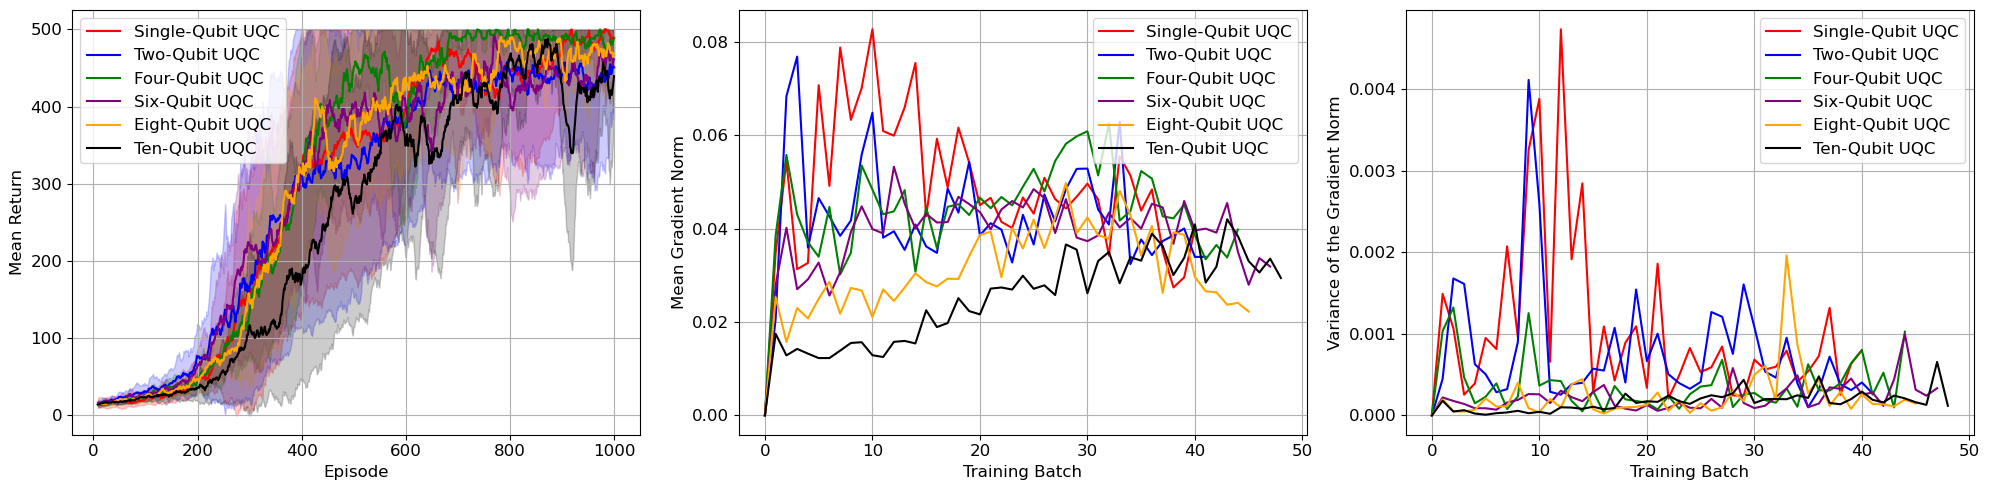

In [19]:
# Create a 1x3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)

# First plot: Rewards mean with fill between for each configuration
axs[0].plot(UQC_FullEnc_1qubits_rewards_mean, color="red", label="Single-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_rewards_mean, color="blue", label="Two-Qubit UQC")
axs[0].plot(UQC_FullEnc_4qubits_rewards_mean, color="green", label="Four-Qubit UQC")
axs[0].plot(UQC_FullEnc_6qubits_rewards_mean, color="purple", label="Six-Qubit UQC")
axs[0].plot(UQC_FullEnc_8qubits_rewards_mean, color="orange", label="Eight-Qubit UQC")
axs[0].plot(UQC_FullEnc_10qubits_rewards_mean, color="black", label="Ten-Qubit UQC")
axs[0].fill_between(np.arange(len(UQC_FullEnc_1qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_1qubits_rewards_mean - UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_1qubits_rewards_mean + UQC_FullEnc_1qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_rewards_mean - UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_2qubits_rewards_mean + UQC_FullEnc_2qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_rewards_mean - UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_4qubits_rewards_mean + UQC_FullEnc_4qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_FullEnc_6qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_6qubits_rewards_mean - UQC_FullEnc_6qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_6qubits_rewards_mean + UQC_FullEnc_6qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_FullEnc_8qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_8qubits_rewards_mean - UQC_FullEnc_8qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_8qubits_rewards_mean + UQC_FullEnc_8qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="orange")
axs[0].fill_between(np.arange(len(UQC_FullEnc_10qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_10qubits_rewards_mean - UQC_FullEnc_10qubits_rewards_std, a_min=0, a_max=500),
                    np.clip(UQC_FullEnc_10qubits_rewards_mean + UQC_FullEnc_10qubits_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="black")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# Second plot: Mean gradient norm for each configuration
axs[1].plot(UQC_FullEnc_1qubits_norm_grads, color="red", label="Single-Qubit UQC")
axs[1].plot(UQC_FullEnc_2qubits_norm_grads, color="blue", label="Two-Qubit UQC")
axs[1].plot(UQC_FullEnc_4qubits_norm_grads, color="green", label="Four-Qubit UQC")
axs[1].plot(UQC_FullEnc_6qubits_norm_grads, color="purple", label="Six-Qubit UQC")
axs[1].plot(UQC_FullEnc_8qubits_norm_grads, color="orange", label="Eight-Qubit UQC")
axs[1].plot(UQC_FullEnc_10qubits_norm_grads, color="black", label="Ten-Qubit UQC")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Third plot: Variance of gradient norm for each configuration
axs[2].plot(UQC_FullEnc_1qubits_variance_grads, color="red", label="Single-Qubit UQC")
axs[2].plot(UQC_FullEnc_2qubits_variance_grads, color="blue", label="Two-Qubit UQC")
axs[2].plot(UQC_FullEnc_4qubits_variance_grads, color="green", label="Four-Qubit UQC")
axs[2].plot(UQC_FullEnc_6qubits_variance_grads, color="purple", label="Six-Qubit UQC")
axs[2].plot(UQC_FullEnc_8qubits_variance_grads, color="orange", label="Eight-Qubit UQC")
axs[2].plot(UQC_FullEnc_10qubits_variance_grads, color="black", label="Ten-Qubit UQC")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

# Save the combined plot as a PDF
plt.savefig("../../../../data/CartPole-v1/UQC/uqc_qubits_cartpole.pdf", format="pdf")

# Show the plot
plt.show()


### Acrobot

In [20]:
UQC_FullEnc_paths = [ "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_1qubits",
                      "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_2qubits",
                      "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits",
                      "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_6qubits",
                      "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_8qubits",
                      "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_10qubits"]

# Initialize Analysis objects
UQC_FullEnc_1qubits = Analysis(UQC_FullEnc_paths[0])
UQC_FullEnc_2qubits = Analysis(UQC_FullEnc_paths[1])
UQC_FullEnc_4qubits = Analysis(UQC_FullEnc_paths[2])
UQC_FullEnc_6qubits = Analysis(UQC_FullEnc_paths[3])
UQC_FullEnc_8qubits = Analysis(UQC_FullEnc_paths[4])
UQC_FullEnc_10qubits = Analysis(UQC_FullEnc_paths[5])

# Compute moving averages for all qubit sizes
UQC_FullEnc_1qubits_rewards = UQC_FullEnc_1qubits.get_moving_average(window_size=10)
UQC_FullEnc_2qubits_rewards = UQC_FullEnc_2qubits.get_moving_average(window_size=10)
UQC_FullEnc_4qubits_rewards = UQC_FullEnc_4qubits.get_moving_average(window_size=10)
UQC_FullEnc_6qubits_rewards = UQC_FullEnc_6qubits.get_moving_average(window_size=10)
UQC_FullEnc_8qubits_rewards = UQC_FullEnc_8qubits.get_moving_average(window_size=10)
UQC_FullEnc_10qubits_rewards = UQC_FullEnc_10qubits.get_moving_average(window_size=10)

UQC_FullEnc_1qubits_rewards_mean = np.mean(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_mean = np.mean(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_mean = np.mean(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_6qubits_rewards_mean = np.mean(UQC_FullEnc_6qubits_rewards, axis=0)
UQC_FullEnc_8qubits_rewards_mean = np.mean(UQC_FullEnc_8qubits_rewards, axis=0)
UQC_FullEnc_10qubits_rewards_mean = np.mean(UQC_FullEnc_10qubits_rewards, axis=0)

UQC_FullEnc_1qubits_rewards_std = np.std(UQC_FullEnc_1qubits_rewards, axis=0)
UQC_FullEnc_2qubits_rewards_std = np.std(UQC_FullEnc_2qubits_rewards, axis=0)
UQC_FullEnc_4qubits_rewards_std = np.std(UQC_FullEnc_4qubits_rewards, axis=0)
UQC_FullEnc_6qubits_rewards_std = np.std(UQC_FullEnc_6qubits_rewards, axis=0)
UQC_FullEnc_8qubits_rewards_std = np.std(UQC_FullEnc_8qubits_rewards, axis=0)
UQC_FullEnc_10qubits_rewards_std = np.std(UQC_FullEnc_10qubits_rewards, axis=0)



# Calculate gradients for all qubit sizes
UQC_FullEnc_1qubits_norm_grads, UQC_FullEnc_1qubits_variance_grads = UQC_FullEnc_1qubits.compute_norm_and_variance()
UQC_FullEnc_2qubits_norm_grads, UQC_FullEnc_2qubits_variance_grads = UQC_FullEnc_2qubits.compute_norm_and_variance()
UQC_FullEnc_4qubits_norm_grads, UQC_FullEnc_4qubits_variance_grads = UQC_FullEnc_4qubits.compute_norm_and_variance()
UQC_FullEnc_6qubits_norm_grads, UQC_FullEnc_6qubits_variance_grads = UQC_FullEnc_6qubits.compute_norm_and_variance()
UQC_FullEnc_8qubits_norm_grads, UQC_FullEnc_8qubits_variance_grads = UQC_FullEnc_8qubits.compute_norm_and_variance()
UQC_FullEnc_10qubits_norm_grads, UQC_FullEnc_10qubits_variance_grads = UQC_FullEnc_10qubits.compute_norm_and_variance()

# Calculate runtimes for all qubit sizes
UQC_FullEnc_1qubits_runtime = sum(map(sum, UQC_FullEnc_1qubits.get_runtime())) / len(UQC_FullEnc_1qubits.get_runtime()) / 60
UQC_FullEnc_2qubits_runtime = sum(map(sum, UQC_FullEnc_2qubits.get_runtime())) / len(UQC_FullEnc_2qubits.get_runtime()) / 60
UQC_FullEnc_4qubits_runtime = sum(map(sum, UQC_FullEnc_4qubits.get_runtime())) / len(UQC_FullEnc_4qubits.get_runtime()) / 60
UQC_FullEnc_6qubits_runtime = sum(map(sum, UQC_FullEnc_6qubits.get_runtime())) / len(UQC_FullEnc_6qubits.get_runtime()) / 60
UQC_FullEnc_8qubits_runtime = sum(map(sum, UQC_FullEnc_8qubits.get_runtime())) / len(UQC_FullEnc_8qubits.get_runtime()) / 60
UQC_FullEnc_10qubits_runtime = sum(map(sum, UQC_FullEnc_10qubits.get_runtime())) / len(UQC_FullEnc_10qubits.get_runtime()) / 60

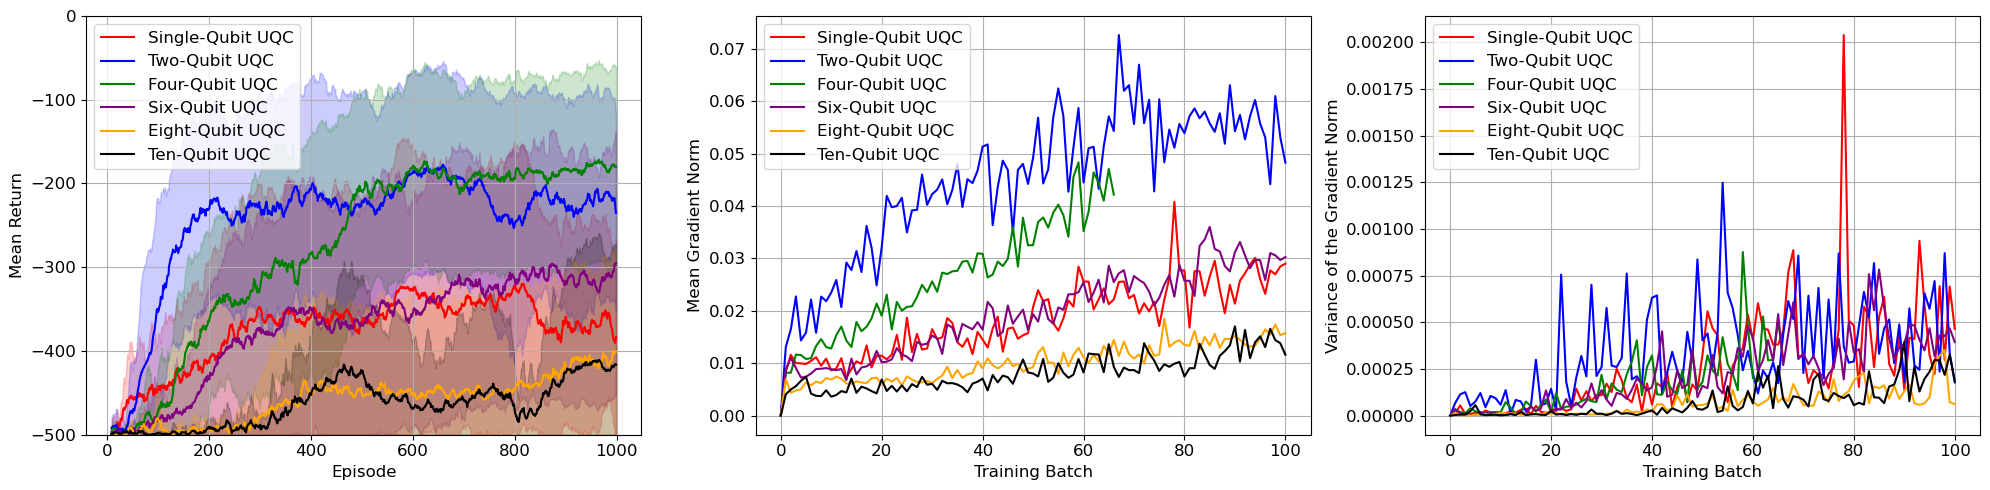

In [21]:
# Create a 1x3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)

# First plot: Rewards mean with fill between for each configuration
axs[0].plot(UQC_FullEnc_1qubits_rewards_mean, color="red", label="Single-Qubit UQC")
axs[0].plot(UQC_FullEnc_2qubits_rewards_mean, color="blue", label="Two-Qubit UQC")
axs[0].plot(UQC_FullEnc_4qubits_rewards_mean, color="green", label="Four-Qubit UQC")
axs[0].plot(UQC_FullEnc_6qubits_rewards_mean, color="purple", label="Six-Qubit UQC")
axs[0].plot(UQC_FullEnc_8qubits_rewards_mean, color="orange", label="Eight-Qubit UQC")
axs[0].plot(UQC_FullEnc_10qubits_rewards_mean, color="black", label="Ten-Qubit UQC")
axs[0].fill_between(np.arange(len(UQC_FullEnc_1qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_1qubits_rewards_mean - UQC_FullEnc_1qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_1qubits_rewards_mean + UQC_FullEnc_1qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(UQC_FullEnc_2qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_2qubits_rewards_mean - UQC_FullEnc_2qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_2qubits_rewards_mean + UQC_FullEnc_2qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(UQC_FullEnc_4qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_4qubits_rewards_mean - UQC_FullEnc_4qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_4qubits_rewards_mean + UQC_FullEnc_4qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(UQC_FullEnc_6qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_6qubits_rewards_mean - UQC_FullEnc_6qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_6qubits_rewards_mean + UQC_FullEnc_6qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="purple")
axs[0].fill_between(np.arange(len(UQC_FullEnc_8qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_8qubits_rewards_mean - UQC_FullEnc_8qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_8qubits_rewards_mean + UQC_FullEnc_8qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="orange")
axs[0].fill_between(np.arange(len(UQC_FullEnc_10qubits_rewards_mean)), 
                    np.clip(UQC_FullEnc_10qubits_rewards_mean - UQC_FullEnc_10qubits_rewards_std, a_min=-500, a_max=0),
                    np.clip(UQC_FullEnc_10qubits_rewards_mean + UQC_FullEnc_10qubits_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="black")
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Mean Return", fontsize=12)
axs[0].set_ylim(-500,0)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# Second plot: Mean gradient norm for each configuration
axs[1].plot(UQC_FullEnc_1qubits_norm_grads, color="red", label="Single-Qubit UQC")
axs[1].plot(UQC_FullEnc_2qubits_norm_grads, color="blue", label="Two-Qubit UQC")
axs[1].plot(UQC_FullEnc_4qubits_norm_grads, color="green", label="Four-Qubit UQC")
axs[1].plot(UQC_FullEnc_6qubits_norm_grads, color="purple", label="Six-Qubit UQC")
axs[1].plot(UQC_FullEnc_8qubits_norm_grads, color="orange", label="Eight-Qubit UQC")
axs[1].plot(UQC_FullEnc_10qubits_norm_grads, color="black", label="Ten-Qubit UQC")
axs[1].set_xlabel("Training Batch", fontsize=12)
axs[1].set_ylabel("Mean Gradient Norm", fontsize=12)
axs[1].legend(fontsize=12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

# Third plot: Variance of gradient norm for each configuration
axs[2].plot(UQC_FullEnc_1qubits_variance_grads, color="red", label="Single-Qubit UQC")
axs[2].plot(UQC_FullEnc_2qubits_variance_grads, color="blue", label="Two-Qubit UQC")
axs[2].plot(UQC_FullEnc_4qubits_variance_grads, color="green", label="Four-Qubit UQC")
axs[2].plot(UQC_FullEnc_6qubits_variance_grads, color="purple", label="Six-Qubit UQC")
axs[2].plot(UQC_FullEnc_8qubits_variance_grads, color="orange", label="Eight-Qubit UQC")
axs[2].plot(UQC_FullEnc_10qubits_variance_grads, color="black", label="Ten-Qubit UQC")
axs[2].set_xlabel("Training Batch", fontsize=12)
axs[2].set_ylabel("Variance of the Gradient Norm", fontsize=12)
axs[2].legend(fontsize=12)
axs[2].xaxis.set_tick_params(labelsize=12)
axs[2].yaxis.set_tick_params(labelsize=12)
axs[2].grid(True)

# Save the combined plot as a PDF
plt.savefig("../../../../data/Acrobot-v1/UQC/uqc_qubits_acrobot.pdf", format="pdf")

# Show the plot
plt.show()


# Jerbi Circuit

## Jerbi Raw vs Softmax

### Cartpole

In [22]:
jerbi_policies_paths = [
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_raw_contiguous",
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_raw_parity",
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer"
]

# Initialize Analysis objects
jerbi_model_raw_contiguous = Analysis(jerbi_policies_paths[0])
jerbi_model_raw_parity = Analysis(jerbi_policies_paths[1])
jerbi_model_softmax = Analysis(jerbi_policies_paths[2])

# Calculate moving averages for rewards
jerbi_model_raw_contiguous_rewards = jerbi_model_raw_contiguous.get_moving_average(window_size=10)
jerbi_model_raw_parity_rewards = jerbi_model_raw_parity.get_moving_average(window_size=10)
jerbi_model_softmax_rewards = jerbi_model_softmax.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_model_raw_contiguous_rewards_mean = np.mean(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_raw_parity_rewards_mean = np.mean(jerbi_model_raw_parity_rewards, axis=0)
jerbi_model_softmax_rewards_mean = np.mean(jerbi_model_softmax_rewards, axis=0)

jerbi_model_raw_contiguous_rewards_std = np.std(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_raw_parity_rewards_std = np.std(jerbi_model_raw_parity_rewards, axis=0)
jerbi_model_softmax_rewards_std = np.std(jerbi_model_softmax_rewards, axis=0)

# Calculate gradients and their variance
jerbi_model_raw_contiguous_norm_grads, jerbi_model_raw_contiguous_variance_grads = jerbi_model_raw_contiguous.compute_norm_and_variance()
jerbi_model_raw_parity_norm_grads, jerbi_model_raw_parity_variance_grads = jerbi_model_raw_parity.compute_norm_and_variance()
jerbi_model_softmax_norm_grads, jerbi_model_softmax_variance_grads = jerbi_model_softmax.compute_norm_and_variance()

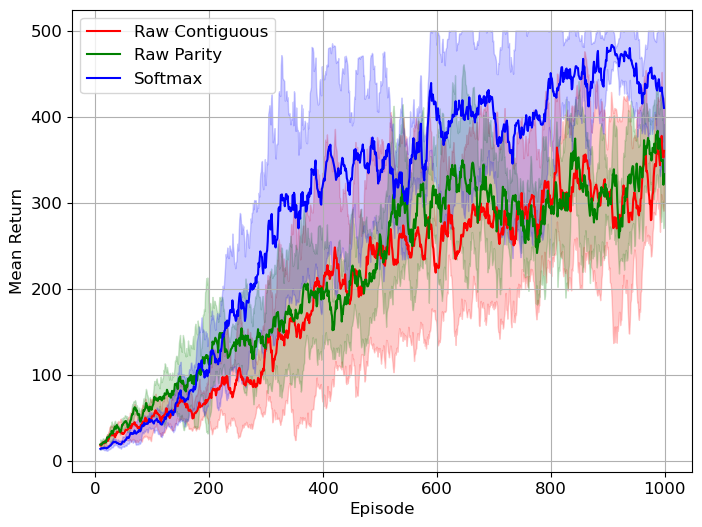

In [23]:
plt.figure(figsize=(8, 6))


plt.plot(jerbi_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
plt.plot(jerbi_model_raw_parity_rewards_mean, color="green", label="Raw Parity")
plt.plot(jerbi_model_softmax_rewards_mean, color="blue", label="Softmax")
plt.fill_between(np.arange(len(jerbi_model_raw_contiguous_rewards_mean)), 
                    np.clip(jerbi_model_raw_contiguous_rewards_mean - jerbi_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_raw_contiguous_rewards_mean + jerbi_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
plt.fill_between(np.arange(len(jerbi_model_raw_parity_rewards_mean)), 
                    np.clip(jerbi_model_raw_parity_rewards_mean - jerbi_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_raw_parity_rewards_mean + jerbi_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
plt.fill_between(np.arange(len(jerbi_model_softmax_rewards_mean)), 
                    np.clip(jerbi_model_softmax_rewards_mean - jerbi_model_softmax_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_softmax_rewards_mean + jerbi_model_softmax_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.grid(True)

plt.savefig("../../../../data/CartPole-v1/JERBI/jerbi_policies_cartpole.pdf", format="pdf")

plt.show()

### Acrobot

In [24]:
jerbi_policies_paths = [
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer_raw_contiguous",
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer"
]

# Initialize Analysis objects
jerbi_model_raw_contiguous = Analysis(jerbi_policies_paths[0])
jerbi_model_softmax = Analysis(jerbi_policies_paths[1])

# Calculate moving averages for rewards
jerbi_model_raw_contiguous_rewards = jerbi_model_raw_contiguous.get_moving_average(window_size=10)
jerbi_model_softmax_rewards = jerbi_model_softmax.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_model_raw_contiguous_rewards_mean = np.mean(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_softmax_rewards_mean = np.mean(jerbi_model_softmax_rewards, axis=0)

jerbi_model_raw_contiguous_rewards_std = np.std(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_softmax_rewards_std = np.std(jerbi_model_softmax_rewards, axis=0)

# Calculate gradients and their variance
jerbi_model_raw_contiguous_norm_grads, jerbi_model_raw_contiguous_variance_grads = jerbi_model_raw_contiguous.compute_norm_and_variance()
jerbi_model_softmax_norm_grads, jerbi_model_softmax_variance_grads = jerbi_model_softmax.compute_norm_and_variance()

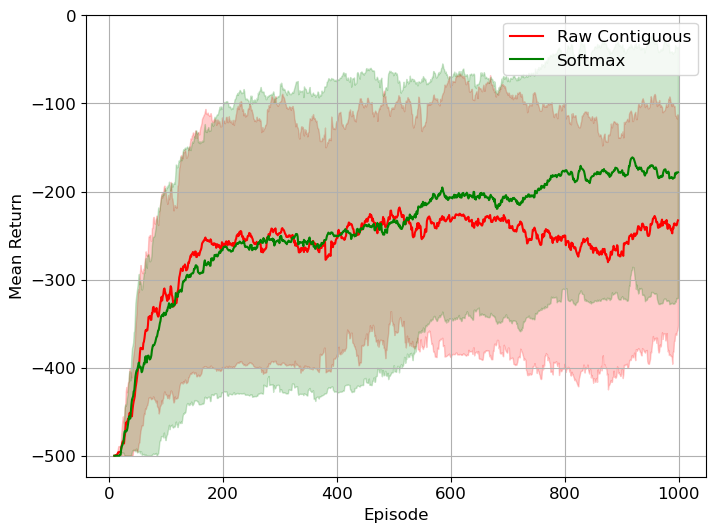

In [25]:
plt.figure(figsize=(8, 6))


plt.plot(jerbi_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
plt.plot(jerbi_model_softmax_rewards_mean, color="green", label="Softmax")
plt.fill_between(np.arange(len(jerbi_model_raw_contiguous_rewards_mean)), 
                    np.clip(jerbi_model_raw_contiguous_rewards_mean - jerbi_model_raw_contiguous_rewards_std, a_min=-500, a_max=0),
                    np.clip(jerbi_model_raw_contiguous_rewards_mean + jerbi_model_raw_contiguous_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="red")
plt.fill_between(np.arange(len(jerbi_model_softmax_rewards_mean)), 
                    np.clip(jerbi_model_softmax_rewards_mean - jerbi_model_softmax_rewards_std, a_min=-500, a_max=0),
                    np.clip(jerbi_model_softmax_rewards_mean + jerbi_model_softmax_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="green")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.grid(True)

plt.savefig("../../../../data/Acrobot-v1/JERBI/jerbi_policies_acrobot.pdf", format="pdf")

plt.show()

## Jerbi Baseline vs Data reup (output and input scalling tests)

### Cartpole

In [26]:
jerbi_baseline_paths = [
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_1layer", 
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_1layer_input", 
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_1layer_output", 
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_1layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_baseline_layer = Analysis(jerbi_baseline_paths[0])
jerbi_baseline_input = Analysis(jerbi_baseline_paths[1])
jerbi_baseline_output = Analysis(jerbi_baseline_paths[2])
jerbi_baseline_input_output = Analysis(jerbi_baseline_paths[3])

# Calculate moving averages for rewards
jerbi_baseline_layer_rewards = jerbi_baseline_layer.get_moving_average(window_size=10)
jerbi_baseline_input_rewards = jerbi_baseline_input.get_moving_average(window_size=10)
jerbi_baseline_output_rewards = jerbi_baseline_output.get_moving_average(window_size=10)
jerbi_baseline_input_output_rewards = jerbi_baseline_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_baseline_layer_rewards_mean = np.mean(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_mean = np.mean(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_mean = np.mean(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_mean = np.mean(jerbi_baseline_input_output_rewards, axis=0)

jerbi_baseline_layer_rewards_std = np.std(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_std = np.std(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_std = np.std(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_std = np.std(jerbi_baseline_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_baseline_layer_norm_grads, jerbi_baseline_layer_variance_grads = jerbi_baseline_layer.compute_norm_and_variance()
jerbi_baseline_input_norm_grads, jerbi_baseline_input_variance_grads = jerbi_baseline_input.compute_norm_and_variance()
jerbi_baseline_output_norm_grads, jerbi_baseline_output_variance_grads = jerbi_baseline_output.compute_norm_and_variance()
jerbi_baseline_input_output_norm_grads, jerbi_baseline_input_output_variance_grads = jerbi_baseline_input_output.compute_norm_and_variance()



jerbi_datareup_paths = [
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer", 
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_input", 
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_output", 
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_datareup_layer = Analysis(jerbi_datareup_paths[0])
jerbi_datareup_input = Analysis(jerbi_datareup_paths[1])
jerbi_datareup_output = Analysis(jerbi_datareup_paths[2])
jerbi_datareup_input_output = Analysis(jerbi_datareup_paths[3])

# Calculate moving averages for rewards
jerbi_datareup_layer_rewards = jerbi_datareup_layer.get_moving_average(window_size=10)
jerbi_datareup_input_rewards = jerbi_datareup_input.get_moving_average(window_size=10)
jerbi_datareup_output_rewards = jerbi_datareup_output.get_moving_average(window_size=10)
jerbi_datareup_input_output_rewards = jerbi_datareup_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_datareup_layer_rewards_mean = np.mean(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_mean = np.mean(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_mean = np.mean(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_mean = np.mean(jerbi_datareup_input_output_rewards, axis=0)

jerbi_datareup_layer_rewards_std = np.std(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_std = np.std(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_std = np.std(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_std = np.std(jerbi_datareup_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_datareup_layer_norm_grads, jerbi_datareup_layer_variance_grads = jerbi_datareup_layer.compute_norm_and_variance()
jerbi_datareup_input_norm_grads, jerbi_datareup_input_variance_grads = jerbi_datareup_input.compute_norm_and_variance()
jerbi_datareup_output_norm_grads, jerbi_datareup_output_variance_grads = jerbi_datareup_output.compute_norm_and_variance()
jerbi_datareup_input_output_norm_grads, jerbi_datareup_input_output_variance_grads = jerbi_datareup_input_output.compute_norm_and_variance()

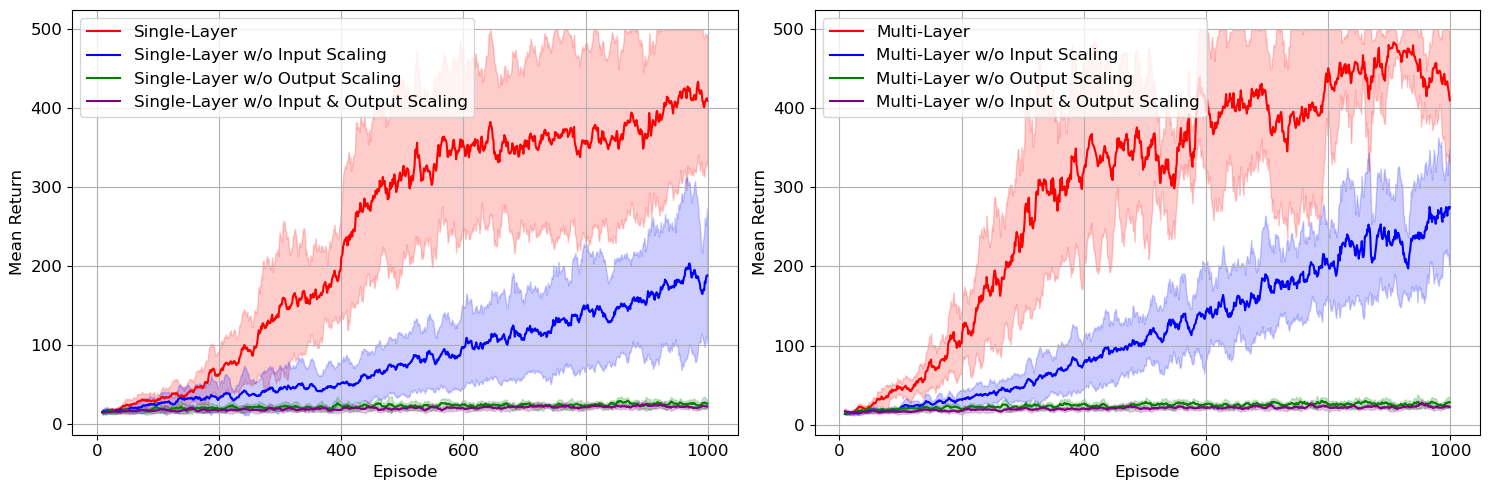

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# First Plot: Baseline
# Plot rewards mean for jerbi_baseline
axs[0].plot(jerbi_baseline_layer_rewards_mean, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_rewards_mean, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_baseline_output_rewards_mean, color="green", label="Single-Layer w/o Output Scaling")
axs[0].plot(jerbi_baseline_input_output_rewards_mean, color="purple", label="Single-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_baseline
axs[0].fill_between(np.arange(len(jerbi_baseline_layer_rewards_mean)), 
                       np.clip(jerbi_baseline_layer_rewards_mean - jerbi_baseline_layer_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_layer_rewards_mean + jerbi_baseline_layer_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_rewards_mean)), 
                       np.clip(jerbi_baseline_input_rewards_mean - jerbi_baseline_input_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_input_rewards_mean + jerbi_baseline_input_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(jerbi_baseline_output_rewards_mean)), 
                       np.clip(jerbi_baseline_output_rewards_mean - jerbi_baseline_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_output_rewards_mean + jerbi_baseline_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_output_rewards_mean)), 
                       np.clip(jerbi_baseline_input_output_rewards_mean - jerbi_baseline_input_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_input_output_rewards_mean + jerbi_baseline_input_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="purple")

axs[0].set_xlabel("Episode", fontsize = 12)
axs[0].set_ylabel("Mean Return", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Second Plot: Datareup
# Plot rewards mean for jerbi_datareup
axs[1].plot(jerbi_datareup_layer_rewards_mean, color="red", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_rewards_mean, color="blue", label="Multi-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_output_rewards_mean, color="green", label="Multi-Layer w/o Output Scaling")
axs[1].plot(jerbi_datareup_input_output_rewards_mean, color="purple", label="Multi-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_datareup
axs[1].fill_between(np.arange(len(jerbi_datareup_layer_rewards_mean)), 
                       np.clip(jerbi_datareup_layer_rewards_mean - jerbi_datareup_layer_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_layer_rewards_mean + jerbi_datareup_layer_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="red")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_rewards_mean)), 
                       np.clip(jerbi_datareup_input_rewards_mean - jerbi_datareup_input_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_input_rewards_mean + jerbi_datareup_input_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(jerbi_datareup_output_rewards_mean)), 
                       np.clip(jerbi_datareup_output_rewards_mean - jerbi_datareup_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_output_rewards_mean + jerbi_datareup_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_output_rewards_mean)), 
                       np.clip(jerbi_datareup_input_output_rewards_mean - jerbi_datareup_input_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_input_output_rewards_mean + jerbi_datareup_input_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="purple")

axs[1].set_xlabel("Episode", fontsize = 12)
axs[1].set_ylabel("Mean Return", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/CartPole-v1/JERBI/jerbi_datareup_cartpole.pdf", format="pdf")

plt.show()

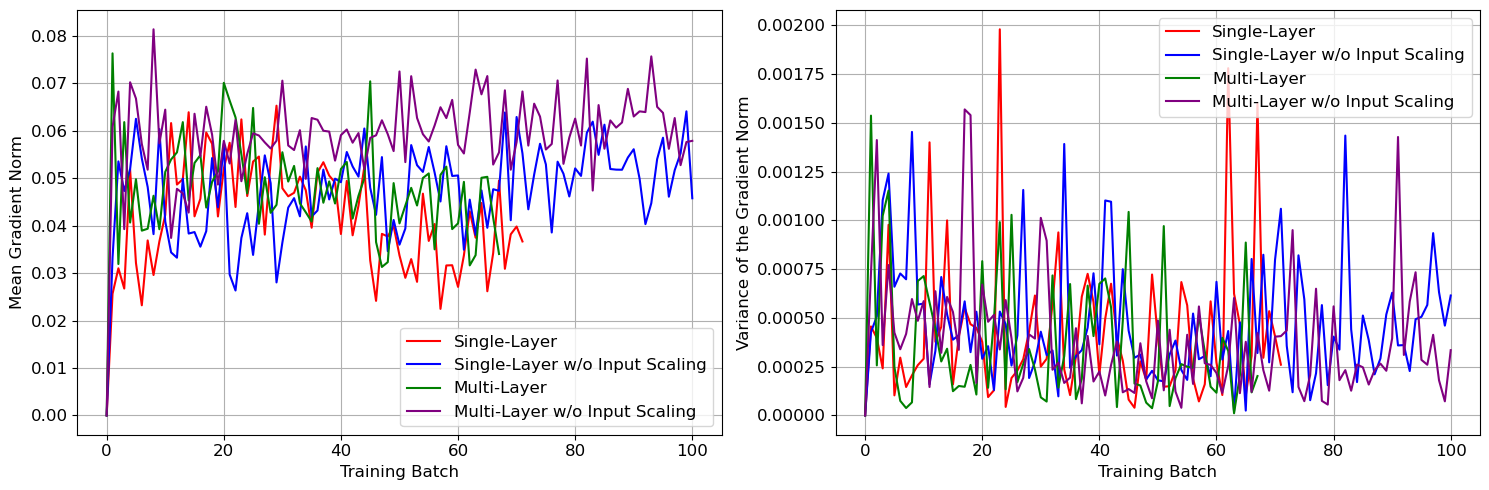

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# Plot mean gradient norm
axs[0].plot(jerbi_baseline_layer_norm_grads, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_norm_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_datareup_layer_norm_grads, color="green", label="Multi-Layer")
axs[0].plot(jerbi_datareup_input_norm_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[0].set_xlabel("Training Batch", fontsize = 12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot variance of gradient norm
axs[1].plot(jerbi_baseline_layer_variance_grads, color="red", label="Single-Layer")
axs[1].plot(jerbi_baseline_input_variance_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_layer_variance_grads, color="green", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_variance_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[1].set_xlabel("Training Batch", fontsize = 12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/CartPole-v1/JERBI/jerbi_gradients_cartpole.pdf", format="pdf")

plt.show()

### Acrobot

In [29]:
jerbi_baseline_paths = [
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_1layer", 
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_1layer_input", 
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_1layer_output", 
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_1layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_baseline_layer = Analysis(jerbi_baseline_paths[0])
jerbi_baseline_input = Analysis(jerbi_baseline_paths[1])
jerbi_baseline_output = Analysis(jerbi_baseline_paths[2])
jerbi_baseline_input_output = Analysis(jerbi_baseline_paths[3])

# Calculate moving averages for rewards
jerbi_baseline_layer_rewards = jerbi_baseline_layer.get_moving_average(window_size=10)
jerbi_baseline_input_rewards = jerbi_baseline_input.get_moving_average(window_size=10)
jerbi_baseline_output_rewards = jerbi_baseline_output.get_moving_average(window_size=10)
jerbi_baseline_input_output_rewards = jerbi_baseline_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_baseline_layer_rewards_mean = np.mean(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_mean = np.mean(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_mean = np.mean(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_mean = np.mean(jerbi_baseline_input_output_rewards, axis=0)

jerbi_baseline_layer_rewards_std = np.std(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_std = np.std(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_std = np.std(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_std = np.std(jerbi_baseline_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_baseline_layer_norm_grads, jerbi_baseline_layer_variance_grads = jerbi_baseline_layer.compute_norm_and_variance()
jerbi_baseline_input_norm_grads, jerbi_baseline_input_variance_grads = jerbi_baseline_input.compute_norm_and_variance()
jerbi_baseline_output_norm_grads, jerbi_baseline_output_variance_grads = jerbi_baseline_output.compute_norm_and_variance()
jerbi_baseline_input_output_norm_grads, jerbi_baseline_input_output_variance_grads = jerbi_baseline_input_output.compute_norm_and_variance()



jerbi_datareup_paths = [
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer", 
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer_input", 
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer_output", 
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_datareup_layer = Analysis(jerbi_datareup_paths[0])
jerbi_datareup_input = Analysis(jerbi_datareup_paths[1])
jerbi_datareup_output = Analysis(jerbi_datareup_paths[2])
jerbi_datareup_input_output = Analysis(jerbi_datareup_paths[3])

# Calculate moving averages for rewards
jerbi_datareup_layer_rewards = jerbi_datareup_layer.get_moving_average(window_size=10)
jerbi_datareup_input_rewards = jerbi_datareup_input.get_moving_average(window_size=10)
jerbi_datareup_output_rewards = jerbi_datareup_output.get_moving_average(window_size=10)
jerbi_datareup_input_output_rewards = jerbi_datareup_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_datareup_layer_rewards_mean = np.mean(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_mean = np.mean(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_mean = np.mean(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_mean = np.mean(jerbi_datareup_input_output_rewards, axis=0)

jerbi_datareup_layer_rewards_std = np.std(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_std = np.std(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_std = np.std(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_std = np.std(jerbi_datareup_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_datareup_layer_norm_grads, jerbi_datareup_layer_variance_grads = jerbi_datareup_layer.compute_norm_and_variance()
jerbi_datareup_input_norm_grads, jerbi_datareup_input_variance_grads = jerbi_datareup_input.compute_norm_and_variance()
jerbi_datareup_output_norm_grads, jerbi_datareup_output_variance_grads = jerbi_datareup_output.compute_norm_and_variance()
jerbi_datareup_input_output_norm_grads, jerbi_datareup_input_output_variance_grads = jerbi_datareup_input_output.compute_norm_and_variance()


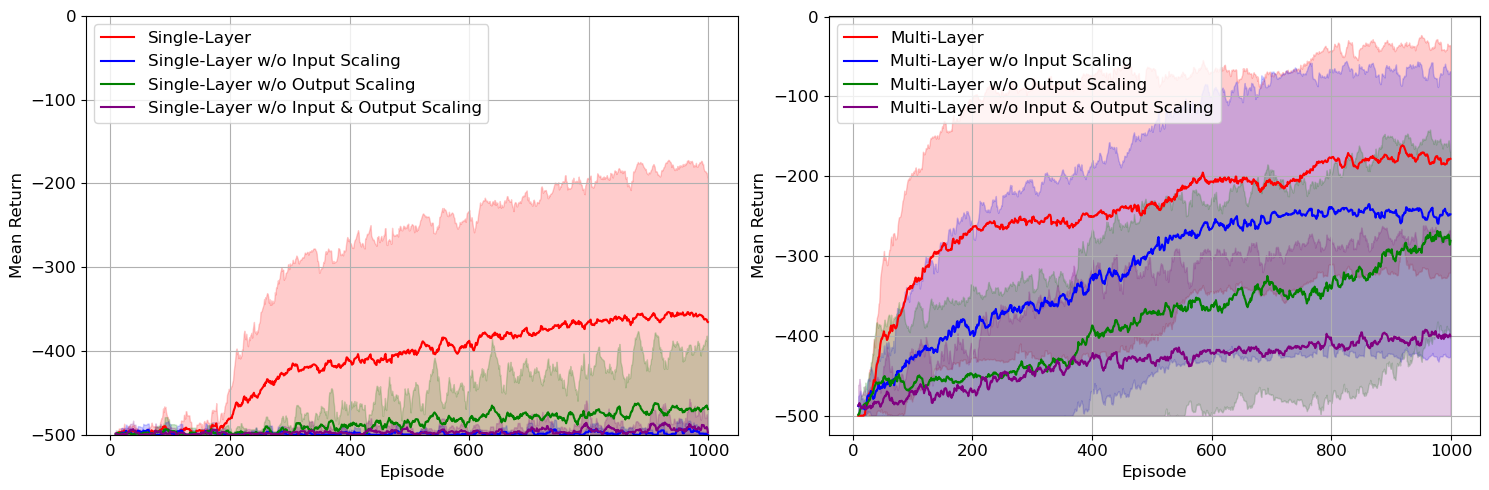

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# First Plot: Baseline
# Plot rewards mean for jerbi_baseline
axs[0].plot(jerbi_baseline_layer_rewards_mean, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_rewards_mean, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_baseline_output_rewards_mean, color="green", label="Single-Layer w/o Output Scaling")
axs[0].plot(jerbi_baseline_input_output_rewards_mean, color="purple", label="Single-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_baseline
axs[0].fill_between(np.arange(len(jerbi_baseline_layer_rewards_mean)), 
                       np.clip(jerbi_baseline_layer_rewards_mean - jerbi_baseline_layer_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_layer_rewards_mean + jerbi_baseline_layer_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_rewards_mean)), 
                       np.clip(jerbi_baseline_input_rewards_mean - jerbi_baseline_input_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_input_rewards_mean + jerbi_baseline_input_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(jerbi_baseline_output_rewards_mean)), 
                       np.clip(jerbi_baseline_output_rewards_mean - jerbi_baseline_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_output_rewards_mean + jerbi_baseline_output_rewards_std, a_min=-500, a_max=-75),
                       alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_output_rewards_mean)), 
                       np.clip(jerbi_baseline_input_output_rewards_mean - jerbi_baseline_input_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_input_output_rewards_mean + jerbi_baseline_input_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="purple")

axs[0].set_xlabel("Episode", fontsize = 12)
axs[0].set_ylabel("Mean Return", fontsize = 12)
axs[0].legend(fontsize = 12, loc='upper left')
axs[0].set_ylim(-500,0)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Second Plot: Datareup
# Plot rewards mean for jerbi_datareup
axs[1].plot(jerbi_datareup_layer_rewards_mean, color="red", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_rewards_mean, color="blue", label="Multi-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_output_rewards_mean, color="green", label="Multi-Layer w/o Output Scaling")
axs[1].plot(jerbi_datareup_input_output_rewards_mean, color="purple", label="Multi-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_datareup
axs[1].fill_between(np.arange(len(jerbi_datareup_layer_rewards_mean)), 
                       np.clip(jerbi_datareup_layer_rewards_mean - jerbi_datareup_layer_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_layer_rewards_mean + jerbi_datareup_layer_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="red")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_rewards_mean)), 
                       np.clip(jerbi_datareup_input_rewards_mean - jerbi_datareup_input_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_input_rewards_mean + jerbi_datareup_input_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(jerbi_datareup_output_rewards_mean)), 
                       np.clip(jerbi_datareup_output_rewards_mean - jerbi_datareup_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_output_rewards_mean + jerbi_datareup_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_output_rewards_mean)), 
                       np.clip(jerbi_datareup_input_output_rewards_mean - jerbi_datareup_input_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_input_output_rewards_mean + jerbi_datareup_input_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="purple")

axs[1].set_xlabel("Episode", fontsize = 12)
axs[1].set_ylabel("Mean Return", fontsize = 12)
axs[1].legend(fontsize = 12, loc='upper left')
axs[0].set_ylim(-500,0)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/Acrobot-v1/JERBI/jerbi_datareup_acrobot.pdf", format="pdf")

plt.show()

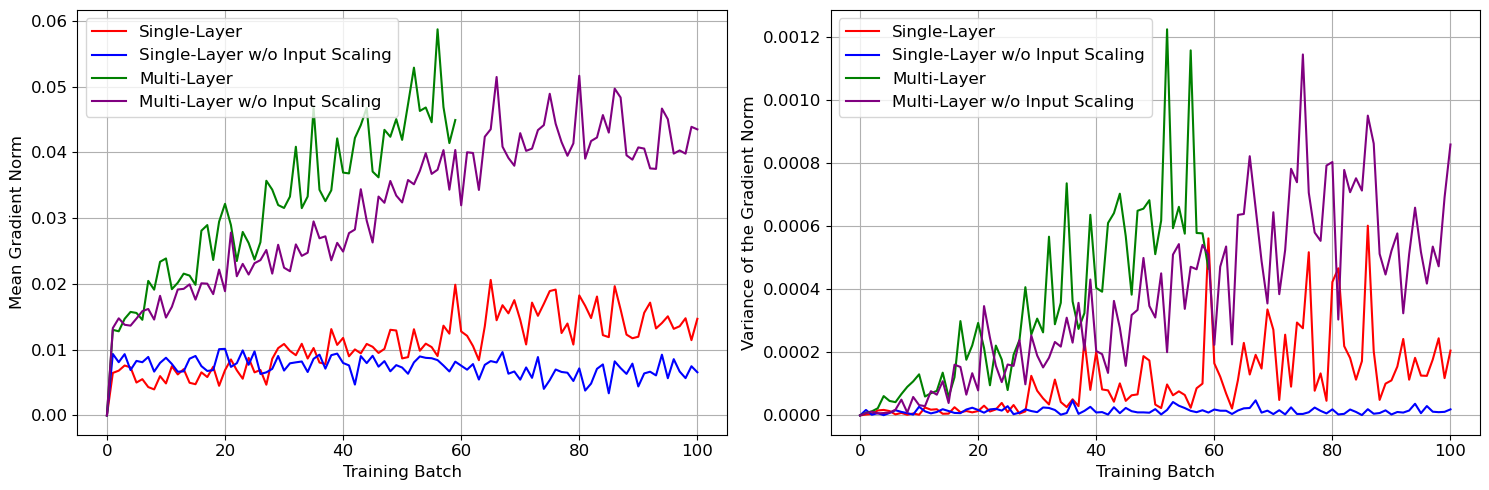

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# Plot mean gradient norm
axs[0].plot(jerbi_baseline_layer_norm_grads, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_norm_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_datareup_layer_norm_grads, color="green", label="Multi-Layer")
axs[0].plot(jerbi_datareup_input_norm_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[0].set_xlabel("Training Batch", fontsize = 12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot variance of gradient norm
axs[1].plot(jerbi_baseline_layer_variance_grads, color="red", label="Single-Layer")
axs[1].plot(jerbi_baseline_input_variance_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_layer_variance_grads, color="green", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_variance_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[1].set_xlabel("Training Batch", fontsize = 12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/Acrobot-v1/JERBI/jerbi_gradients_acrobot.pdf", format="pdf")

plt.show()

## Jerbi beta tests

### Cartpole

In [32]:
jerbi_paths = [
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer",
    "../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer_beta",
]

# Initialize Analysis objects
jerbi = Analysis(jerbi_paths[0])
jerbi_beta = Analysis(jerbi_paths[1])

# Calculate moving averages for rewards
jerbi_rewards = jerbi.get_moving_average(window_size=10)
jerbi_beta_rewards = jerbi_beta.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
jerbi_beta_rewards_mean = np.mean(jerbi_beta_rewards, axis=0)
jerbi_rewards_std = np.std(jerbi_rewards, axis=0)
jerbi_beta_rewards_std = np.std(jerbi_beta_rewards, axis=0)

# Compute mean loss
jerbi_loss = jerbi.compute_mean_loss()
jerbi_beta_loss = jerbi_beta.compute_mean_loss()

# Calculate gradients and their variance
jerbi_norm_grads, jerbi_variance_grads = jerbi.compute_norm_and_variance()
jerbi_beta_norm_grads, jerbi_beta_variance_grads = jerbi_beta.compute_norm_and_variance()


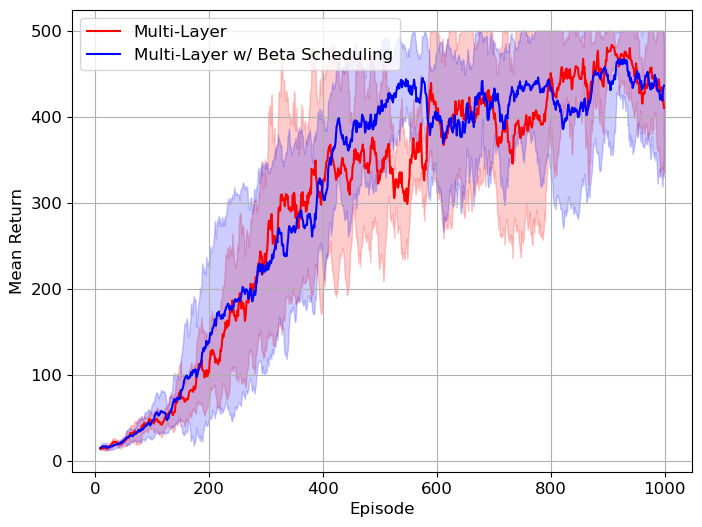

In [33]:
plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_rewards_mean, color="red", label="Multi-Layer")
plt.plot(jerbi_beta_rewards_mean, color="blue", label="Multi-Layer w/ Beta Scheduling")

# Fill between for standard deviation
plt.fill_between(np.arange(len(jerbi_rewards_mean)), 
                 np.clip(jerbi_rewards_mean - jerbi_rewards_std, a_min=0, a_max=500),
                 np.clip(jerbi_rewards_mean + jerbi_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="red")

plt.fill_between(np.arange(len(jerbi_beta_rewards_mean)), 
                 np.clip(jerbi_beta_rewards_mean - jerbi_beta_rewards_std, a_min=0, a_max=500),
                 np.clip(jerbi_beta_rewards_mean + jerbi_beta_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="blue")

# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.savefig("../../../../data/CartPole-v1/JERBI/jerbi_beta_cartpole.pdf", format="pdf")
plt.show()

### Acrobot

In [34]:
jerbi_paths = [
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer",
    "../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer_beta",
]

# Initialize Analysis objects
jerbi = Analysis(jerbi_paths[0])
jerbi_beta = Analysis(jerbi_paths[1])

# Calculate moving averages for rewards
jerbi_rewards = jerbi.get_moving_average(window_size=10)
jerbi_beta_rewards = jerbi_beta.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
jerbi_beta_rewards_mean = np.mean(jerbi_beta_rewards, axis=0)
jerbi_rewards_std = np.std(jerbi_rewards, axis=0)
jerbi_beta_rewards_std = np.std(jerbi_beta_rewards, axis=0)

# Compute mean loss
jerbi_loss = jerbi.compute_mean_loss()
jerbi_beta_loss = jerbi_beta.compute_mean_loss()

# Calculate gradients and their variance
jerbi_norm_grads, jerbi_variance_grads = jerbi.compute_norm_and_variance()
jerbi_beta_norm_grads, jerbi_beta_variance_grads = jerbi_beta.compute_norm_and_variance()


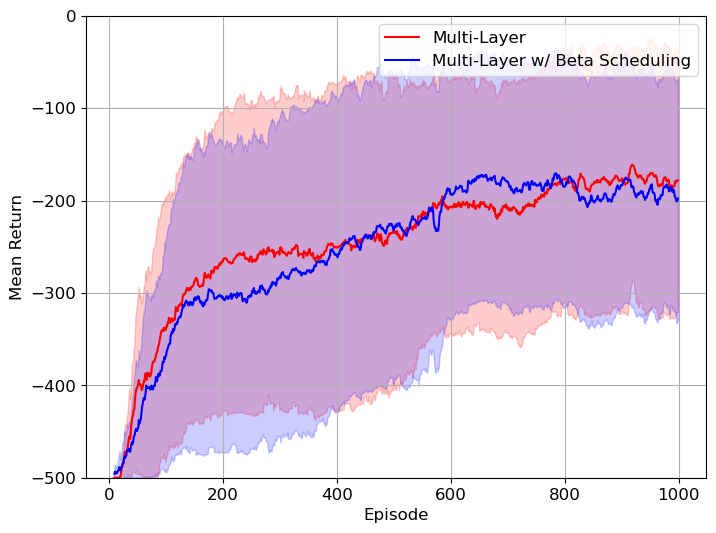

In [35]:
plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_rewards_mean, color="red", label="Multi-Layer")
plt.plot(jerbi_beta_rewards_mean, color="blue", label="Multi-Layer w/ Beta Scheduling")

# Fill between for standard deviation
plt.fill_between(np.arange(len(jerbi_rewards_mean)), 
                 np.clip(jerbi_rewards_mean - jerbi_rewards_std, a_min=-500, a_max=0),
                 np.clip(jerbi_rewards_mean + jerbi_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="red")

plt.fill_between(np.arange(len(jerbi_beta_rewards_mean)), 
                 np.clip(jerbi_beta_rewards_mean - jerbi_beta_rewards_std, a_min=-500, a_max=0),
                 np.clip(jerbi_beta_rewards_mean + jerbi_beta_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="blue")

# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.ylim(-500,0)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.grid(True)

plt.savefig("../../../../data/Acrobot-v1/JERBI/jerbi_beta_acrobot.pdf", format="pdf")
plt.show()

# TFQ Circuit

## TFQ Raw vs Softmax

### Cartpole

In [36]:
jerbi_policies_paths = [
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer_raw_contiguous",
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer_raw_parity",
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer"
]

# Initialize Analysis objects
jerbi_model_raw_contiguous = Analysis(jerbi_policies_paths[0])
jerbi_model_raw_parity = Analysis(jerbi_policies_paths[1])
jerbi_model_softmax = Analysis(jerbi_policies_paths[2])

# Calculate moving averages for rewards
jerbi_model_raw_contiguous_rewards = jerbi_model_raw_contiguous.get_moving_average(window_size=10)
jerbi_model_raw_parity_rewards = jerbi_model_raw_parity.get_moving_average(window_size=10)
jerbi_model_softmax_rewards = jerbi_model_softmax.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_model_raw_contiguous_rewards_mean = np.mean(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_raw_parity_rewards_mean = np.mean(jerbi_model_raw_parity_rewards, axis=0)
jerbi_model_softmax_rewards_mean = np.mean(jerbi_model_softmax_rewards, axis=0)

jerbi_model_raw_contiguous_rewards_std = np.std(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_raw_parity_rewards_std = np.std(jerbi_model_raw_parity_rewards, axis=0)
jerbi_model_softmax_rewards_std = np.std(jerbi_model_softmax_rewards, axis=0)

# Calculate gradients and their variance
jerbi_model_raw_contiguous_norm_grads, jerbi_model_raw_contiguous_variance_grads = jerbi_model_raw_contiguous.compute_norm_and_variance()
jerbi_model_raw_parity_norm_grads, jerbi_model_raw_parity_variance_grads = jerbi_model_raw_parity.compute_norm_and_variance()
jerbi_model_softmax_norm_grads, jerbi_model_softmax_variance_grads = jerbi_model_softmax.compute_norm_and_variance()

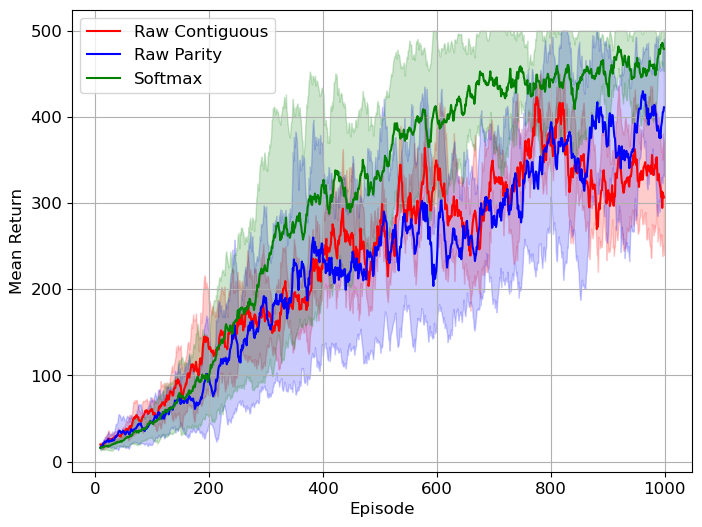

In [37]:
plt.figure(figsize=(8, 6))


plt.plot(jerbi_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
plt.plot(jerbi_model_raw_parity_rewards_mean, color="blue", label="Raw Parity")
plt.plot(jerbi_model_softmax_rewards_mean, color="green", label="Softmax")
plt.fill_between(np.arange(len(jerbi_model_raw_contiguous_rewards_mean)), 
                    np.clip(jerbi_model_raw_contiguous_rewards_mean - jerbi_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_raw_contiguous_rewards_mean + jerbi_model_raw_contiguous_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="red")
plt.fill_between(np.arange(len(jerbi_model_raw_parity_rewards_mean)), 
                    np.clip(jerbi_model_raw_parity_rewards_mean - jerbi_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_raw_parity_rewards_mean + jerbi_model_raw_parity_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="blue")
plt.fill_between(np.arange(len(jerbi_model_softmax_rewards_mean)), 
                    np.clip(jerbi_model_softmax_rewards_mean - jerbi_model_softmax_rewards_std, a_min=0, a_max=500),
                    np.clip(jerbi_model_softmax_rewards_mean + jerbi_model_softmax_rewards_std, a_min=0, a_max=500),
                    alpha=0.2, color="green")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.grid(True)

plt.savefig("../../../../data/CartPole-v1/TFQ/tfq_policies_cartpole.pdf", format="pdf")

plt.show()

### Acrobot

In [38]:
jerbi_policies_paths = [
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer_raw_contiguous",
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer"
]

# Initialize Analysis objects
jerbi_model_raw_contiguous = Analysis(jerbi_policies_paths[0])
jerbi_model_softmax = Analysis(jerbi_policies_paths[1])

# Calculate moving averages for rewards
jerbi_model_raw_contiguous_rewards = jerbi_model_raw_contiguous.get_moving_average(window_size=10)
jerbi_model_softmax_rewards = jerbi_model_softmax.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_model_raw_contiguous_rewards_mean = np.mean(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_softmax_rewards_mean = np.mean(jerbi_model_softmax_rewards, axis=0)

jerbi_model_raw_contiguous_rewards_std = np.std(jerbi_model_raw_contiguous_rewards, axis=0)
jerbi_model_softmax_rewards_std = np.std(jerbi_model_softmax_rewards, axis=0)

# Calculate gradients and their variance
jerbi_model_raw_contiguous_norm_grads, jerbi_model_raw_contiguous_variance_grads = jerbi_model_raw_contiguous.compute_norm_and_variance()
jerbi_model_softmax_norm_grads, jerbi_model_softmax_variance_grads = jerbi_model_softmax.compute_norm_and_variance()

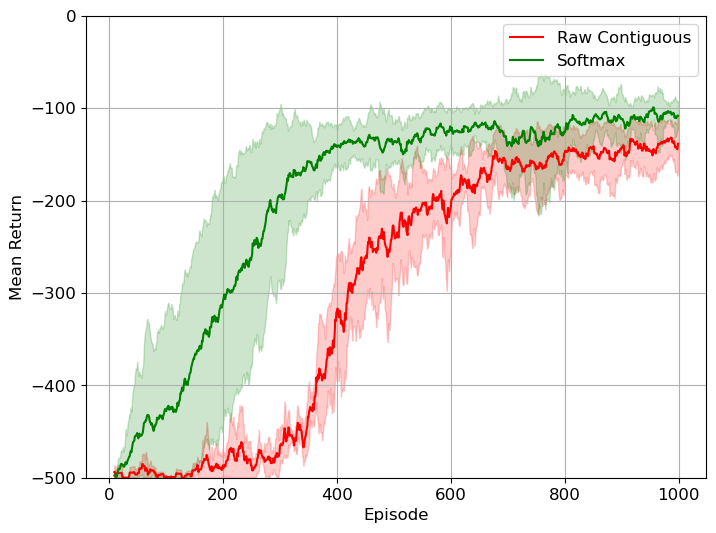

In [39]:
plt.figure(figsize=(8, 6))


plt.plot(jerbi_model_raw_contiguous_rewards_mean, color="red", label="Raw Contiguous")
plt.plot(jerbi_model_softmax_rewards_mean, color="green", label="Softmax")
plt.fill_between(np.arange(len(jerbi_model_raw_contiguous_rewards_mean)), 
                    np.clip(jerbi_model_raw_contiguous_rewards_mean - jerbi_model_raw_contiguous_rewards_std, a_min=-500, a_max=0),
                    np.clip(jerbi_model_raw_contiguous_rewards_mean + jerbi_model_raw_contiguous_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="red")
plt.fill_between(np.arange(len(jerbi_model_softmax_rewards_mean)), 
                    np.clip(jerbi_model_softmax_rewards_mean - jerbi_model_softmax_rewards_std, a_min=-500, a_max=0),
                    np.clip(jerbi_model_softmax_rewards_mean + jerbi_model_softmax_rewards_std, a_min=-500, a_max=0),
                    alpha=0.2, color="green")
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.ylim(-500,0)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.grid(True)

plt.savefig("../../../../data/Acrobot-v1/TFQ/tfq_policies_acrobot.pdf", format="pdf")

plt.show()

## TFQ Baseline vs Data reup (output and input scalling tests)

### Cartpole

In [40]:
jerbi_baseline_paths = [
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_1layer", 
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_1layer_input", 
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_1layer_output", 
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_1layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_baseline_layer = Analysis(jerbi_baseline_paths[0])
jerbi_baseline_input = Analysis(jerbi_baseline_paths[1])
jerbi_baseline_output = Analysis(jerbi_baseline_paths[2])
jerbi_baseline_input_output = Analysis(jerbi_baseline_paths[3])

# Calculate moving averages for rewards
jerbi_baseline_layer_rewards = jerbi_baseline_layer.get_moving_average(window_size=10)
jerbi_baseline_input_rewards = jerbi_baseline_input.get_moving_average(window_size=10)
jerbi_baseline_output_rewards = jerbi_baseline_output.get_moving_average(window_size=10)
jerbi_baseline_input_output_rewards = jerbi_baseline_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_baseline_layer_rewards_mean = np.mean(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_mean = np.mean(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_mean = np.mean(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_mean = np.mean(jerbi_baseline_input_output_rewards, axis=0)

jerbi_baseline_layer_rewards_std = np.std(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_std = np.std(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_std = np.std(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_std = np.std(jerbi_baseline_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_baseline_layer_norm_grads, jerbi_baseline_layer_variance_grads = jerbi_baseline_layer.compute_norm_and_variance()
jerbi_baseline_input_norm_grads, jerbi_baseline_input_variance_grads = jerbi_baseline_input.compute_norm_and_variance()
jerbi_baseline_output_norm_grads, jerbi_baseline_output_variance_grads = jerbi_baseline_output.compute_norm_and_variance()
jerbi_baseline_input_output_norm_grads, jerbi_baseline_input_output_variance_grads = jerbi_baseline_input_output.compute_norm_and_variance()



jerbi_datareup_paths = [
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer", 
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer_input", 
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer_output", 
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_datareup_layer = Analysis(jerbi_datareup_paths[0])
jerbi_datareup_input = Analysis(jerbi_datareup_paths[1])
jerbi_datareup_output = Analysis(jerbi_datareup_paths[2])
jerbi_datareup_input_output = Analysis(jerbi_datareup_paths[3])

# Calculate moving averages for rewards
jerbi_datareup_layer_rewards = jerbi_datareup_layer.get_moving_average(window_size=10)
jerbi_datareup_input_rewards = jerbi_datareup_input.get_moving_average(window_size=10)
jerbi_datareup_output_rewards = jerbi_datareup_output.get_moving_average(window_size=10)
jerbi_datareup_input_output_rewards = jerbi_datareup_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_datareup_layer_rewards_mean = np.mean(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_mean = np.mean(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_mean = np.mean(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_mean = np.mean(jerbi_datareup_input_output_rewards, axis=0)

jerbi_datareup_layer_rewards_std = np.std(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_std = np.std(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_std = np.std(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_std = np.std(jerbi_datareup_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_datareup_layer_norm_grads, jerbi_datareup_layer_variance_grads = jerbi_datareup_layer.compute_norm_and_variance()
jerbi_datareup_input_norm_grads, jerbi_datareup_input_variance_grads = jerbi_datareup_input.compute_norm_and_variance()
jerbi_datareup_output_norm_grads, jerbi_datareup_output_variance_grads = jerbi_datareup_output.compute_norm_and_variance()
jerbi_datareup_input_output_norm_grads, jerbi_datareup_input_output_variance_grads = jerbi_datareup_input_output.compute_norm_and_variance()


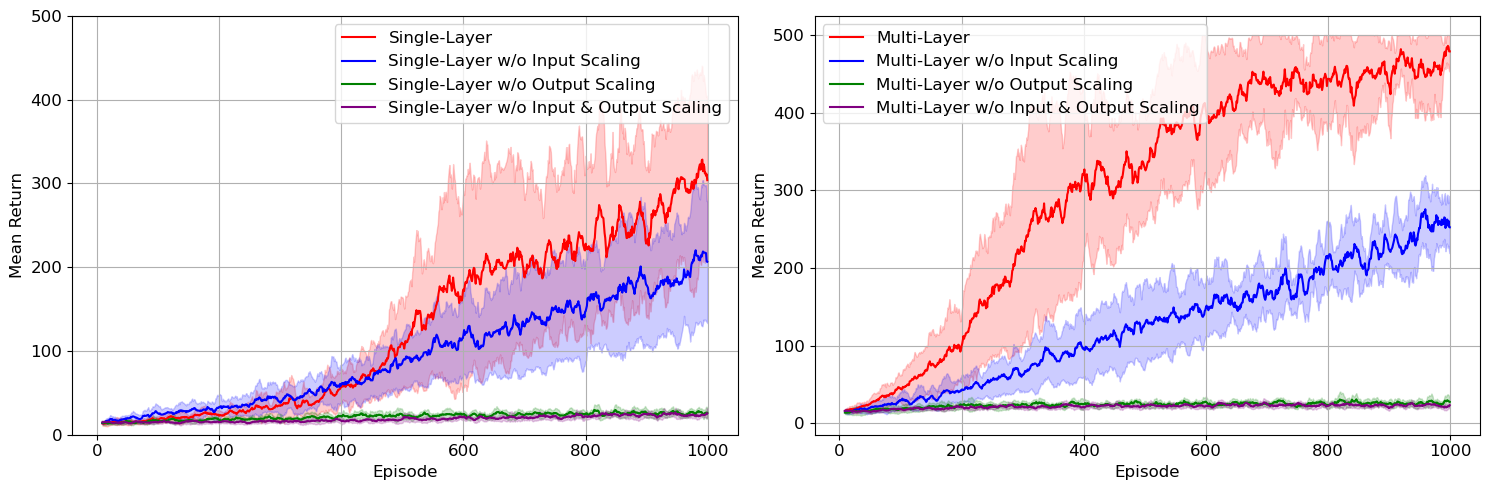

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# First Plot: Baseline
# Plot rewards mean for jerbi_baseline
axs[0].plot(jerbi_baseline_layer_rewards_mean, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_rewards_mean, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_baseline_output_rewards_mean, color="green", label="Single-Layer w/o Output Scaling")
axs[0].plot(jerbi_baseline_input_output_rewards_mean, color="purple", label="Single-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_baseline
axs[0].fill_between(np.arange(len(jerbi_baseline_layer_rewards_mean)), 
                       np.clip(jerbi_baseline_layer_rewards_mean - jerbi_baseline_layer_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_layer_rewards_mean + jerbi_baseline_layer_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_rewards_mean)), 
                       np.clip(jerbi_baseline_input_rewards_mean - jerbi_baseline_input_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_input_rewards_mean + jerbi_baseline_input_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(jerbi_baseline_output_rewards_mean)), 
                       np.clip(jerbi_baseline_output_rewards_mean - jerbi_baseline_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_output_rewards_mean + jerbi_baseline_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_output_rewards_mean)), 
                       np.clip(jerbi_baseline_input_output_rewards_mean - jerbi_baseline_input_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_baseline_input_output_rewards_mean + jerbi_baseline_input_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="purple")

axs[0].set_xlabel("Episode", fontsize = 12)
axs[0].set_ylabel("Mean Return", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].set_ylim(0,500)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Second Plot: Datareup
# Plot rewards mean for jerbi_datareup
axs[1].plot(jerbi_datareup_layer_rewards_mean, color="red", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_rewards_mean, color="blue", label="Multi-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_output_rewards_mean, color="green", label="Multi-Layer w/o Output Scaling")
axs[1].plot(jerbi_datareup_input_output_rewards_mean, color="purple", label="Multi-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_datareup
axs[1].fill_between(np.arange(len(jerbi_datareup_layer_rewards_mean)), 
                       np.clip(jerbi_datareup_layer_rewards_mean - jerbi_datareup_layer_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_layer_rewards_mean + jerbi_datareup_layer_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="red")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_rewards_mean)), 
                       np.clip(jerbi_datareup_input_rewards_mean - jerbi_datareup_input_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_input_rewards_mean + jerbi_datareup_input_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(jerbi_datareup_output_rewards_mean)), 
                       np.clip(jerbi_datareup_output_rewards_mean - jerbi_datareup_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_output_rewards_mean + jerbi_datareup_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_output_rewards_mean)), 
                       np.clip(jerbi_datareup_input_output_rewards_mean - jerbi_datareup_input_output_rewards_std, a_min=0, a_max=500),
                       np.clip(jerbi_datareup_input_output_rewards_mean + jerbi_datareup_input_output_rewards_std, a_min=0, a_max=500),
                       alpha=0.2, color="purple")

axs[1].set_xlabel("Episode", fontsize = 12)
axs[1].set_ylabel("Mean Return", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/Cartpole-v1/TFQ/tfq_datareup_cartpole.pdf", format="pdf")

plt.show()

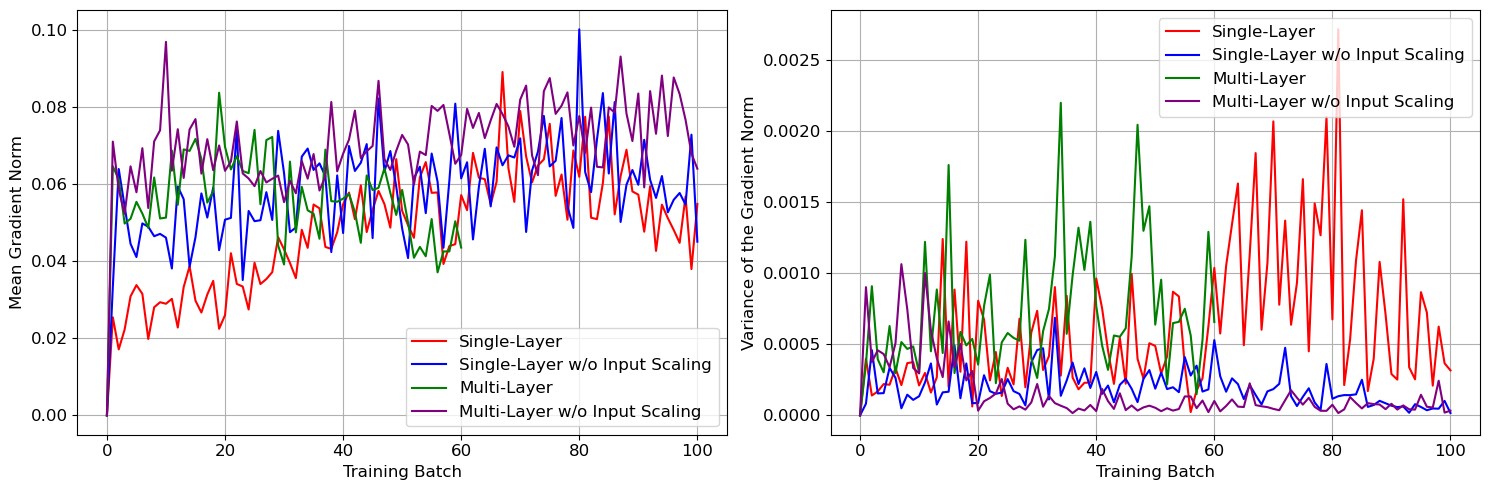

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# Plot mean gradient norm
axs[0].plot(jerbi_baseline_layer_norm_grads, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_norm_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_datareup_layer_norm_grads, color="green", label="Multi-Layer")
axs[0].plot(jerbi_datareup_input_norm_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[0].set_xlabel("Training Batch", fontsize = 12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot variance of gradient norm
axs[1].plot(jerbi_baseline_layer_variance_grads, color="red", label="Single-Layer")
axs[1].plot(jerbi_baseline_input_output_variance_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_layer_variance_grads, color="green", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_output_variance_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[1].set_xlabel("Training Batch", fontsize = 12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/Cartpole-v1/TFQ/tfq_cartpole_gradients.pdf", format="pdf")

plt.show()

### Acrobot

In [43]:
jerbi_baseline_paths = [
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_1layer", 
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_1layer_input", 
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_1layer_output", 
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_1layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_baseline_layer = Analysis(jerbi_baseline_paths[0])
jerbi_baseline_input = Analysis(jerbi_baseline_paths[1])
jerbi_baseline_output = Analysis(jerbi_baseline_paths[2])
jerbi_baseline_input_output = Analysis(jerbi_baseline_paths[3])

# Calculate moving averages for rewards
jerbi_baseline_layer_rewards = jerbi_baseline_layer.get_moving_average(window_size=10)
jerbi_baseline_input_rewards = jerbi_baseline_input.get_moving_average(window_size=10)
jerbi_baseline_output_rewards = jerbi_baseline_output.get_moving_average(window_size=10)
jerbi_baseline_input_output_rewards = jerbi_baseline_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_baseline_layer_rewards_mean = np.mean(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_mean = np.mean(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_mean = np.mean(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_mean = np.mean(jerbi_baseline_input_output_rewards, axis=0)

jerbi_baseline_layer_rewards_std = np.std(jerbi_baseline_layer_rewards, axis=0)
jerbi_baseline_input_rewards_std = np.std(jerbi_baseline_input_rewards, axis=0)
jerbi_baseline_output_rewards_std = np.std(jerbi_baseline_output_rewards, axis=0)
jerbi_baseline_input_output_rewards_std = np.std(jerbi_baseline_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_baseline_layer_norm_grads, jerbi_baseline_layer_variance_grads = jerbi_baseline_layer.compute_norm_and_variance()
jerbi_baseline_input_norm_grads, jerbi_baseline_input_variance_grads = jerbi_baseline_input.compute_norm_and_variance()
jerbi_baseline_output_norm_grads, jerbi_baseline_output_variance_grads = jerbi_baseline_output.compute_norm_and_variance()
jerbi_baseline_input_output_norm_grads, jerbi_baseline_input_output_variance_grads = jerbi_baseline_input_output.compute_norm_and_variance()



jerbi_datareup_paths = [
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer", 
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer_input", 
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer_output", 
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer_input_output"
]

# Initialize Analysis objects for the updated paths
jerbi_datareup_layer = Analysis(jerbi_datareup_paths[0])
jerbi_datareup_input = Analysis(jerbi_datareup_paths[1])
jerbi_datareup_output = Analysis(jerbi_datareup_paths[2])
jerbi_datareup_input_output = Analysis(jerbi_datareup_paths[3])

# Calculate moving averages for rewards
jerbi_datareup_layer_rewards = jerbi_datareup_layer.get_moving_average(window_size=10)
jerbi_datareup_input_rewards = jerbi_datareup_input.get_moving_average(window_size=10)
jerbi_datareup_output_rewards = jerbi_datareup_output.get_moving_average(window_size=10)
jerbi_datareup_input_output_rewards = jerbi_datareup_input_output.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_datareup_layer_rewards_mean = np.mean(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_mean = np.mean(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_mean = np.mean(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_mean = np.mean(jerbi_datareup_input_output_rewards, axis=0)

jerbi_datareup_layer_rewards_std = np.std(jerbi_datareup_layer_rewards, axis=0)
jerbi_datareup_input_rewards_std = np.std(jerbi_datareup_input_rewards, axis=0)
jerbi_datareup_output_rewards_std = np.std(jerbi_datareup_output_rewards, axis=0)
jerbi_datareup_input_output_rewards_std = np.std(jerbi_datareup_input_output_rewards, axis=0)

# Calculate gradients and their variance
jerbi_dataeup_layer_norm_grads, jerbi_ddataeup_layer_variance_grads = jerbi_datareup_layer.compute_norm_and_variance()
jerbi_datareup_input_norm_grads, jerbi_datareup_input_variance_grads = jerbi_datareup_input.compute_norm_and_variance()
jerbi_dataeup_output_norm_grads, jerbi_datareup_output_variance_grads = jerbi_datareup_output.compute_norm_and_variance()
jerbi_datareup_input_output_norm_grads, jerbi_datareup_input_output_variance_grads = jerbi_datareup_input_output.compute_norm_and_variance()


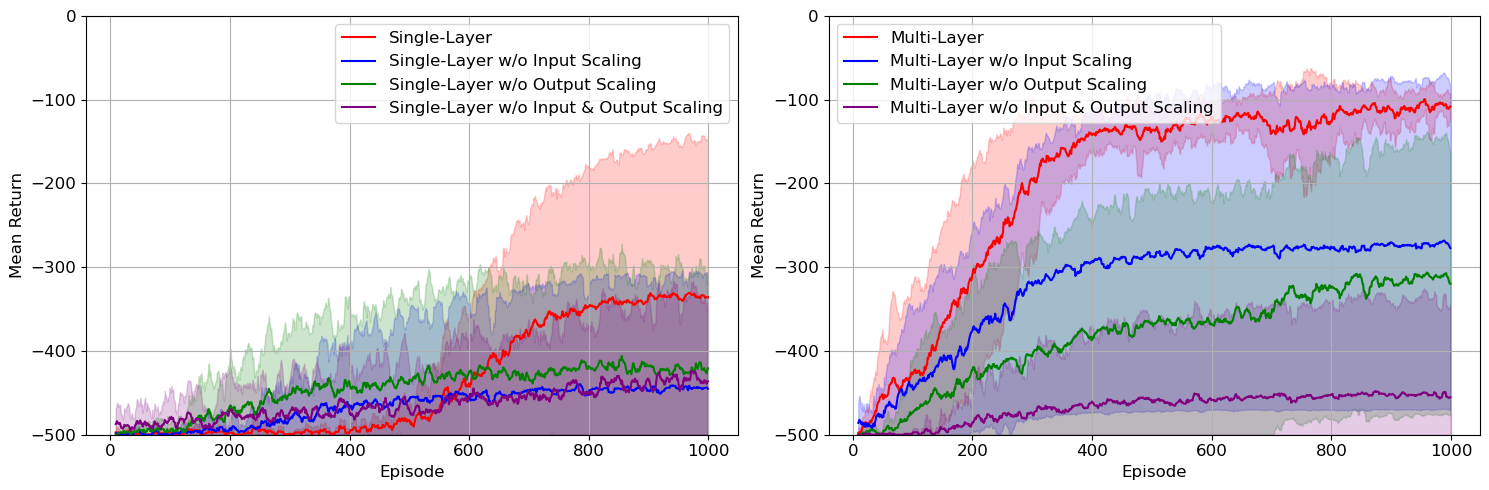

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# First Plot: Baseline
# Plot rewards mean for jerbi_baseline
axs[0].plot(jerbi_baseline_layer_rewards_mean, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_rewards_mean, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_baseline_output_rewards_mean, color="green", label="Single-Layer w/o Output Scaling")
axs[0].plot(jerbi_baseline_input_output_rewards_mean, color="purple", label="Single-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_baseline
axs[0].fill_between(np.arange(len(jerbi_baseline_layer_rewards_mean)), 
                       np.clip(jerbi_baseline_layer_rewards_mean - jerbi_baseline_layer_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_layer_rewards_mean + jerbi_baseline_layer_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="red")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_rewards_mean)), 
                       np.clip(jerbi_baseline_input_rewards_mean - jerbi_baseline_input_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_input_rewards_mean + jerbi_baseline_input_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="blue")
axs[0].fill_between(np.arange(len(jerbi_baseline_output_rewards_mean)), 
                       np.clip(jerbi_baseline_output_rewards_mean - jerbi_baseline_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_output_rewards_mean + jerbi_baseline_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="green")
axs[0].fill_between(np.arange(len(jerbi_baseline_input_output_rewards_mean)), 
                       np.clip(jerbi_baseline_input_output_rewards_mean - jerbi_baseline_input_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_baseline_input_output_rewards_mean + jerbi_baseline_input_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="purple")

axs[0].set_xlabel("Episode", fontsize = 12)
axs[0].set_ylabel("Mean Return", fontsize = 12)
axs[0].set_ylim(-500,0)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].legend(fontsize = 12)
axs[0].grid(True)

# Second Plot: Datareup
# Plot rewards mean for jerbi_datareup
axs[1].plot(jerbi_datareup_layer_rewards_mean, color="red", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_rewards_mean, color="blue", label="Multi-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_output_rewards_mean, color="green", label="Multi-Layer w/o Output Scaling")
axs[1].plot(jerbi_datareup_input_output_rewards_mean, color="purple", label="Multi-Layer w/o Input & Output Scaling")

# Fill between for standard deviation for jerbi_datareup
axs[1].fill_between(np.arange(len(jerbi_datareup_layer_rewards_mean)), 
                       np.clip(jerbi_datareup_layer_rewards_mean - jerbi_datareup_layer_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_layer_rewards_mean + jerbi_datareup_layer_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="red")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_rewards_mean)), 
                       np.clip(jerbi_datareup_input_rewards_mean - jerbi_datareup_input_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_input_rewards_mean + jerbi_datareup_input_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="blue")
axs[1].fill_between(np.arange(len(jerbi_datareup_output_rewards_mean)), 
                       np.clip(jerbi_datareup_output_rewards_mean - jerbi_datareup_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_output_rewards_mean + jerbi_datareup_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="green")
axs[1].fill_between(np.arange(len(jerbi_datareup_input_output_rewards_mean)), 
                       np.clip(jerbi_datareup_input_output_rewards_mean - jerbi_datareup_input_output_rewards_std, a_min=-500, a_max=0),
                       np.clip(jerbi_datareup_input_output_rewards_mean + jerbi_datareup_input_output_rewards_std, a_min=-500, a_max=0),
                       alpha=0.2, color="purple")

axs[1].set_xlabel("Episode", fontsize = 12)
axs[1].set_ylabel("Mean Return", fontsize = 12)
axs[1].set_ylim(-500,0)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].legend(fontsize = 12)
axs[1].grid(True)

plt.savefig("../../../../data/Acrobot-v1/TFQ/tfq_datareup_acrobot.pdf", format="pdf")

plt.show()

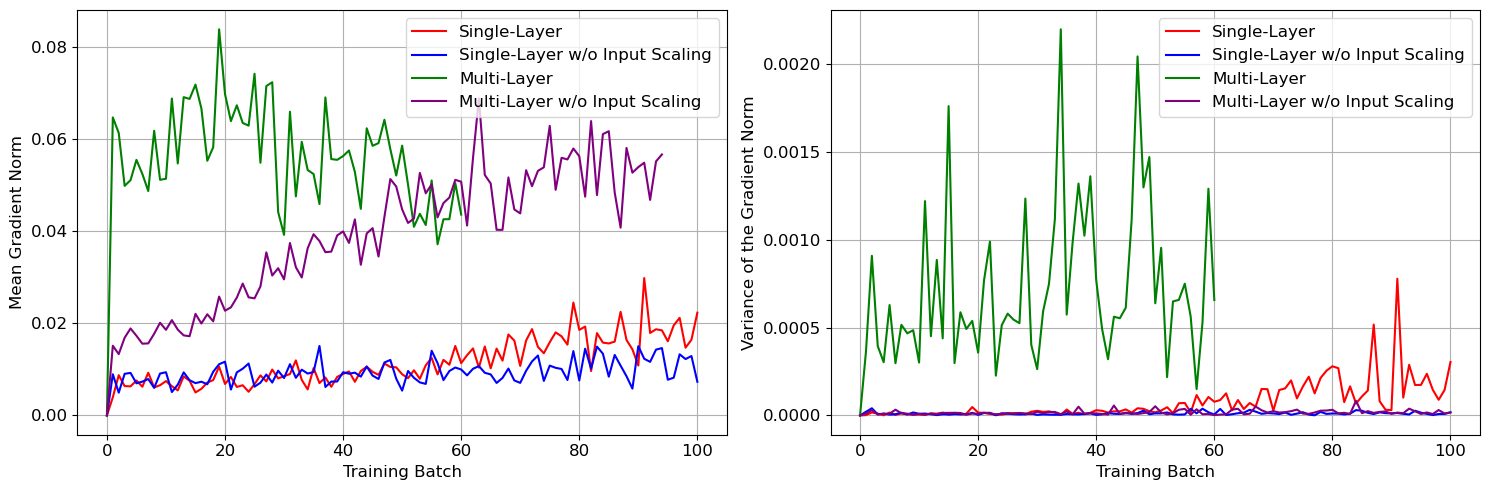

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# Plot mean gradient norm
axs[0].plot(jerbi_baseline_layer_norm_grads, color="red", label="Single-Layer")
axs[0].plot(jerbi_baseline_input_norm_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[0].plot(jerbi_datareup_layer_norm_grads, color="green", label="Multi-Layer")
axs[0].plot(jerbi_datareup_input_norm_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[0].set_xlabel("Training Batch", fontsize = 12)
axs[0].set_ylabel("Mean Gradient Norm", fontsize = 12)
axs[0].legend(fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize=12)
axs[0].yaxis.set_tick_params(labelsize=12)
axs[0].grid(True)

# Plot variance of gradient norm
axs[1].plot(jerbi_baseline_layer_variance_grads, color="red", label="Single-Layer")
axs[1].plot(jerbi_baseline_input_output_variance_grads, color="blue", label="Single-Layer w/o Input Scaling")
axs[1].plot(jerbi_datareup_layer_variance_grads, color="green", label="Multi-Layer")
axs[1].plot(jerbi_datareup_input_output_variance_grads, color="purple", label="Multi-Layer w/o Input Scaling")
axs[1].set_xlabel("Training Batch", fontsize = 12)
axs[1].set_ylabel("Variance of the Gradient Norm", fontsize = 12)
axs[1].legend(fontsize = 12)
axs[1].xaxis.set_tick_params(labelsize=12)
axs[1].yaxis.set_tick_params(labelsize=12)
axs[1].grid(True)

plt.savefig("../../../../data/Acrobot-v1/TFQ/tfq_gradients_acrobot.pdf", format="pdf")

plt.show()

## TFQ beta tests

### Cartpole

In [46]:
jerbi_paths = [
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer",
    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer_beta",
]

# Initialize Analysis objects
jerbi = Analysis(jerbi_paths[0])
jerbi_beta = Analysis(jerbi_paths[1])

# Calculate moving averages for rewards
jerbi_rewards = jerbi.get_moving_average(window_size=10)
jerbi_beta_rewards = jerbi_beta.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
jerbi_beta_rewards_mean = np.mean(jerbi_beta_rewards, axis=0)
jerbi_rewards_std = np.std(jerbi_rewards, axis=0)
jerbi_beta_rewards_std = np.std(jerbi_beta_rewards, axis=0)

# Compute mean loss
jerbi_loss = jerbi.compute_mean_loss()
jerbi_beta_loss = jerbi_beta.compute_mean_loss()

# Calculate gradients and their variance
jerbi_norm_grads, jerbi_variance_grads = jerbi.compute_norm_and_variance()
jerbi_beta_norm_grads, jerbi_beta_variance_grads = jerbi_beta.compute_norm_and_variance()


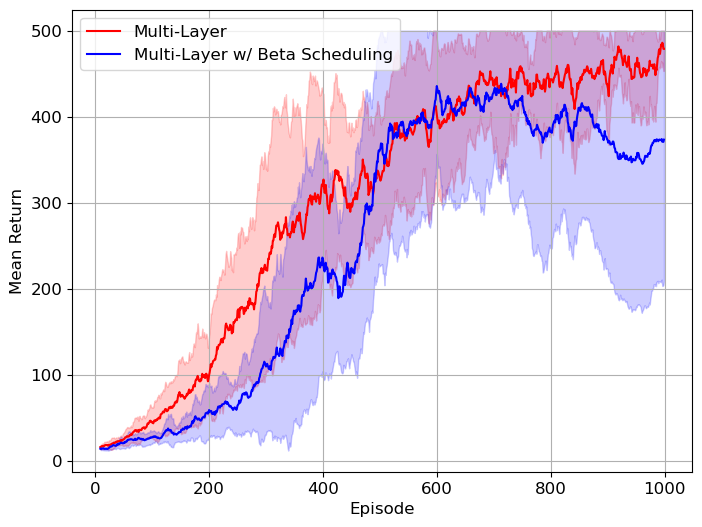

In [47]:
plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_rewards_mean, color="red", label="Multi-Layer")
plt.plot(jerbi_beta_rewards_mean, color="blue", label="Multi-Layer w/ Beta Scheduling")

# Fill between for standard deviation
plt.fill_between(np.arange(len(jerbi_rewards_mean)), 
                 np.clip(jerbi_rewards_mean - jerbi_rewards_std, a_min=0, a_max=500),
                 np.clip(jerbi_rewards_mean + jerbi_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="red")

plt.fill_between(np.arange(len(jerbi_beta_rewards_mean)), 
                 np.clip(jerbi_beta_rewards_mean - jerbi_beta_rewards_std, a_min=0, a_max=500),
                 np.clip(jerbi_beta_rewards_mean + jerbi_beta_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="blue")

# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.savefig("../../../../data/CartPole-v1/TFQ/tfq_beta_cartpole.pdf", format="pdf")
plt.show()

### Acrobot

In [48]:
jerbi_paths = [
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer",
    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer_beta",
]

# Initialize Analysis objects
jerbi = Analysis(jerbi_paths[0])
jerbi_beta = Analysis(jerbi_paths[1])

# Calculate moving averages for rewards
jerbi_rewards = jerbi.get_moving_average(window_size=10)
jerbi_beta_rewards = jerbi_beta.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
jerbi_beta_rewards_mean = np.mean(jerbi_beta_rewards, axis=0)
jerbi_rewards_std = np.std(jerbi_rewards, axis=0)
jerbi_beta_rewards_std = np.std(jerbi_beta_rewards, axis=0)

# Compute mean loss
jerbi_loss = jerbi.compute_mean_loss()
jerbi_beta_loss = jerbi_beta.compute_mean_loss()

# Calculate gradients and their variance
jerbi_norm_grads, jerbi_variance_grads = jerbi.compute_norm_and_variance()
jerbi_beta_norm_grads, jerbi_beta_variance_grads = jerbi_beta.compute_norm_and_variance()


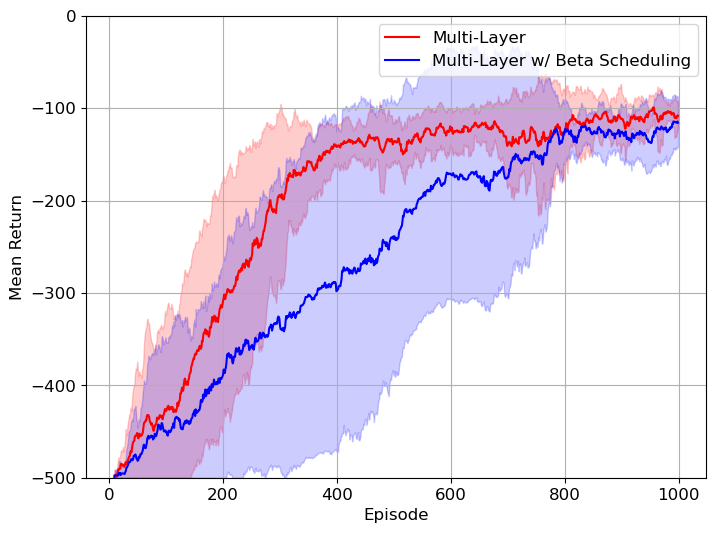

In [49]:
plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_rewards_mean, color="red", label="Multi-Layer")
plt.plot(jerbi_beta_rewards_mean, color="blue", label="Multi-Layer w/ Beta Scheduling")

# Fill between for standard deviation
plt.fill_between(np.arange(len(jerbi_rewards_mean)), 
                 np.clip(jerbi_rewards_mean - jerbi_rewards_std, a_min=-500, a_max=0),
                 np.clip(jerbi_rewards_mean + jerbi_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="red")

plt.fill_between(np.arange(len(jerbi_beta_rewards_mean)), 
                 np.clip(jerbi_beta_rewards_mean - jerbi_beta_rewards_std, a_min=-500, a_max=0),
                 np.clip(jerbi_beta_rewards_mean + jerbi_beta_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="blue")

# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.ylim(-500,0)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.savefig("../../../../data/Acrobot-v1/TFQ/tfq_beta_acrobot.pdf", format="pdf")
plt.show()

# Best Models

### Cartpole

In [50]:
best_models_paths= ["../../../../data/CartPole-v1/JERBI/JerbiModel_4qubits_5layer",
                    "../../../../data/CartPole-v1/TFQ/TfqTutorial_4qubits_5layer",
                    "../../../../data/CartPole-v1/UQC/UQC_FullEnc_4qubits"
]

jerbi = Analysis(best_models_paths[0])
tfq = Analysis(best_models_paths[1])
uqc = Analysis(best_models_paths[2])

jerbi_rewards = jerbi.get_moving_average(window_size=10)
tfq_rewards = tfq.get_moving_average(window_size=10)
uqc_rewards = uqc.get_moving_average(window_size=10)


jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
tfq_rewards_mean = np.mean(tfq_rewards, axis=0)
uqc_rewards_mean = np.mean(uqc_rewards, axis=0)


jerbi_rewards_std = np.std(jerbi_rewards, axis=0)
tfq_rewards_std = np.std(tfq_rewards, axis=0)
uqc_rewards_std = np.std(uqc_rewards, axis=0)

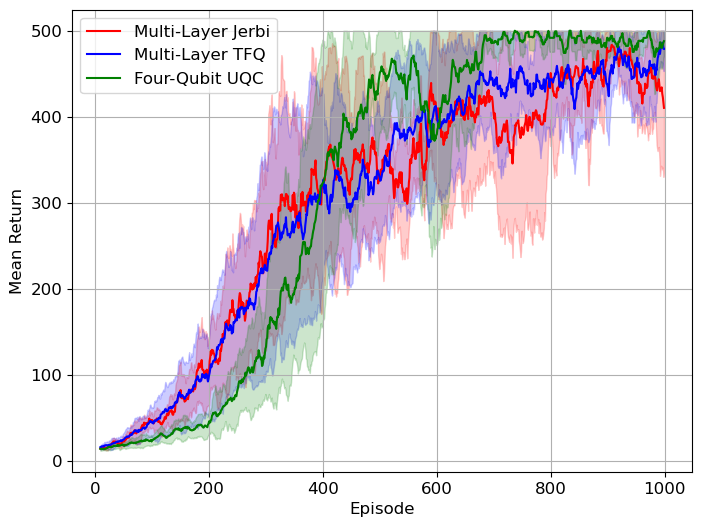

In [51]:
plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_rewards_mean, color="red", label="Multi-Layer Jerbi")
plt.plot(tfq_rewards_mean, color="blue", label="Multi-Layer TFQ")
plt.plot(uqc_rewards_mean, color="green", label="Four-Qubit UQC")

# Fill between for standard deviation
plt.fill_between(np.arange(len(jerbi_rewards_mean)), 
                 np.clip(jerbi_rewards_mean - jerbi_rewards_std, a_min=0, a_max=500),
                 np.clip(jerbi_rewards_mean + jerbi_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="red")

plt.fill_between(np.arange(len(tfq_rewards_mean)), 
                 np.clip(tfq_rewards_mean - tfq_rewards_std, a_min=0, a_max=500),
                 np.clip(tfq_rewards_mean + tfq_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="blue")

plt.fill_between(np.arange(len(uqc_rewards_mean)), 
                 np.clip(uqc_rewards_mean - uqc_rewards_std, a_min=0, a_max=500),
                 np.clip(uqc_rewards_mean + uqc_rewards_std, a_min=0, a_max=500),
                 alpha=0.2, color="green")

# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.savefig("../../../../data/CartPole-v1/best_models_cartpole.pdf", format="pdf")

plt.show()

### Acrobot

In [52]:
best_models_paths= ["../../../../data/Acrobot-v1/JERBI/JerbiModel_4qubits_5layer",
                    "../../../../data/Acrobot-v1/TFQ/TfqTutorial_4qubits_5layer",
                    "../../../../data/Acrobot-v1/UQC/UQC_FullEnc_4qubits"
]

jerbi = Analysis(best_models_paths[0])
tfq = Analysis(best_models_paths[1])
uqc = Analysis(best_models_paths[2])

jerbi_rewards = jerbi.get_moving_average(window_size=10)
tfq_rewards = tfq.get_moving_average(window_size=10)
uqc_rewards = uqc.get_moving_average(window_size=10)


jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
tfq_rewards_mean = np.mean(tfq_rewards, axis=0)
uqc_rewards_mean = np.mean(uqc_rewards, axis=0)


jerbi_rewards_std = np.std(jerbi_rewards, axis=0)
tfq_rewards_std = np.std(tfq_rewards, axis=0)
uqc_rewards_std = np.std(uqc_rewards, axis=0)

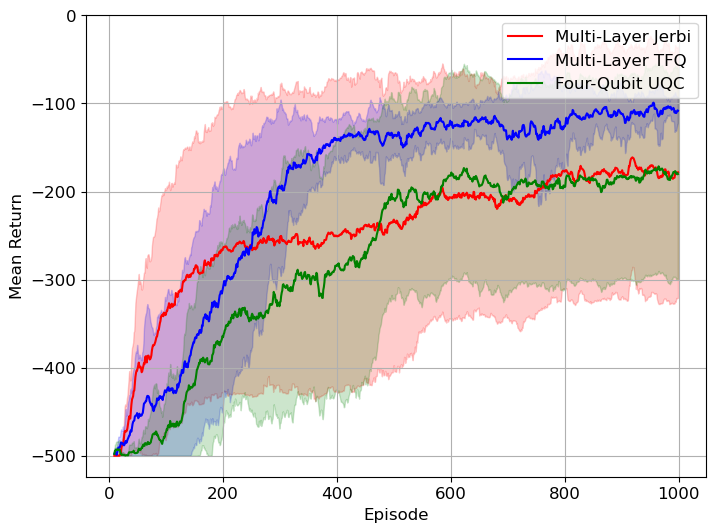

In [53]:
plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_rewards_mean, color="red", label="Multi-Layer Jerbi")
plt.plot(tfq_rewards_mean, color="blue", label="Multi-Layer TFQ")
plt.plot(uqc_rewards_mean, color="green", label="Four-Qubit UQC")

# Fill between for standard deviation
plt.fill_between(np.arange(len(jerbi_rewards_mean)), 
                 np.clip(jerbi_rewards_mean - jerbi_rewards_std, a_min=-500, a_max=0),
                 np.clip(jerbi_rewards_mean + jerbi_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="red")

plt.fill_between(np.arange(len(tfq_rewards_mean)), 
                 np.clip(tfq_rewards_mean - tfq_rewards_std, a_min=-500, a_max=0),
                 np.clip(tfq_rewards_mean + tfq_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="blue")

plt.fill_between(np.arange(len(uqc_rewards_mean)), 
                 np.clip(uqc_rewards_mean - uqc_rewards_std, a_min=-500, a_max=0),
                 np.clip(uqc_rewards_mean + uqc_rewards_std, a_min=-500, a_max=0),
                 alpha=0.2, color="green")

# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Mean Return", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.savefig("../../../../data/Acrobot-v1/best_models_cartpole.pdf", format="pdf")

plt.show()

# Gradients w/o normlize inputs (only 2 batches)

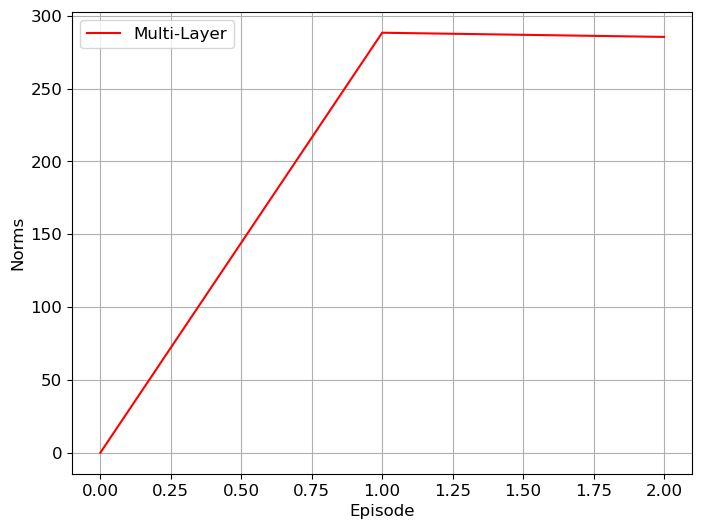

In [114]:
jerbi_paths = [
    "../../../../data/Acrobot-v1/UQC_FullEnc_4qubits_5layer_2024-09-27_15.42.48"]
# Initialize Analysis objects
jerbi = Analysis(jerbi_paths[0])

# Calculate moving averages for rewards
jerbi_rewards = jerbi.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
jerbi_rewards_std = np.std(jerbi_rewards, axis=0)

# Compute mean loss
jerbi_loss = jerbi.compute_mean_loss()

# Calculate gradients and their variance
jerbi_norm_grads, jerbi_variance_grads = jerbi.compute_norm_and_variance()

plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_norm_grads, color="red", label="Multi-Layer")

# Fill between for standard deviation


# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Norms", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.show()

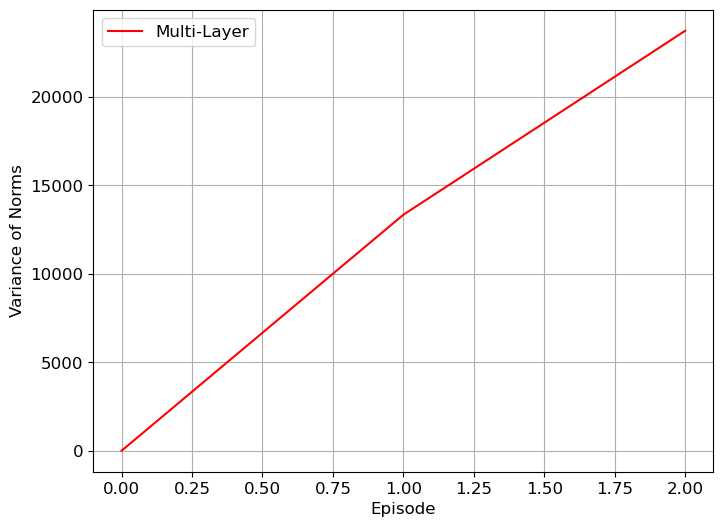

In [115]:
jerbi_paths = [
    "../../../../data/Acrobot-v1/UQC_FullEnc_4qubits_5layer_2024-09-27_15.42.48"]
# Initialize Analysis objects
jerbi = Analysis(jerbi_paths[0])

# Calculate moving averages for rewards
jerbi_rewards = jerbi.get_moving_average(window_size=10)

# Compute mean and std for rewards
jerbi_rewards_mean = np.mean(jerbi_rewards, axis=0)
jerbi_rewards_std = np.std(jerbi_rewards, axis=0)

# Compute mean loss
jerbi_loss = jerbi.compute_mean_loss()

# Calculate gradients and their variance
jerbi_norm_grads, jerbi_variance_grads = jerbi.compute_norm_and_variance()

plt.figure(figsize=(8, 6))

# Plot rewards mean
plt.plot(jerbi_variance_grads, color="red", label="Multi-Layer")

# Fill between for standard deviation


# Labels, legend, and grid
plt.xlabel("Episode", fontsize = 12)
plt.ylabel("Variance of Norms", fontsize = 12)
plt.legend(fontsize = 12)
plt.gca().xaxis.set_tick_params(labelsize=12)  # Set x-axis tick size
plt.gca().yaxis.set_tick_params(labelsize=12)  # Set y-axis tick size
plt.grid(True)

plt.show()